### Objective: TO look at the correlation between charges in different regions of antibodies FV region. 

For this Analysis, I am looking at the distribution of charges in the Therapeutic and MPK190 variants. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
from pathlib import Path
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import seq1, seq3

from dask import delayed, compute
from tqdm.notebook import tqdm

from developability.utils import ls, plot_correlogram
from developability.descriptors import calculate_descriptors

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

#### Set up data paths

In [2]:
DATAPATH = Path('/Users/ChristopherRivera/Documents/DataResults/')

therapeutic_ab_path = DATAPATH / 'TherapeuticAntibodies/solved_protein_electrostatics'
mpk190_v10_path = DATAPATH/ 'MPK190/v10-mutagenesis'

In [3]:
def calculate_charge(chain_sequence, pH=7.4):
    """Calculate the charge of a protein chain as a function of residue number.
    This was written by Github Copilot. Thanks Copilot!

    Args:
        chain_sequence (str): A string representing the amino acid sequence of the protein chain.
        pH (float): The pH value to use for the calculation. Default is 7.4.

    Returns:
        pandas.DataFrame: A DataFrame with columns 'Residue_number', 'Amino_acid', and 'Charge', where
        'Residue_number' is the index of the residue in the protein chain, 'Amino_acid' is the single-letter
        code for the amino acid, and 'Charge' is the charge of the residue at the given pH.

    Notes:
        This function assumes that the input protein chain sequence is a string of single-letter amino acid codes.
        The pKa values used in the calculation are taken from the literature (see references).
        The Henderson-Hasselbalch equation is used to calculate the charge of each residue based on its pKa value
        and the pH of the solution.

    References:
        - Lehninger, A. L., Nelson, D. L., & Cox, M. M. (2008). Principles of biochemistry (5th ed.).
          New York: W.H. Freeman and Co.
        - Voet, D., Voet, J. G., & Pratt, C. W. (2016). Fundamentals of biochemistry: life at the molecular level
          (5th ed.). Hoboken, NJ: Wiley.
    """
    # Define the pKa values for each amino acid side chain
    pKa_values = {
        "R":12.48,
        "D":3.90, 
        "E":4.07,
        "H":6.04,
        "K":10.54
    }

    # Calculate the charge of each residue
    charges = []
    for i, aa in enumerate(chain_sequence):
        pKa = pKa_values.get(aa, None)
        if pKa is not None:
            charge = (10 ** (pH - pKa)) / (1 + 10 ** (pH - pKa))
            if aa in ['D', 'E']:
                charge = -charge
            charges.append(charge)
        else:
            charges.append(np.nan)

    # Create a DataFrame with the residue numbers, amino acids, and charges
    df = pd.DataFrame({'Residue_number': range(1, len(chain_sequence) + 1), 'Amino_acid': list(chain_sequence), 'Charge': charges})

    return df


def get_annotated_residue_potential_files(base_path):
    """Get the annotated residue potential files for the given base path."""
    file_name = 'residue_potential.annotated.csv'
    csvs = {}
    for path in ls(base_path):
        if path.is_dir() and file_name in ls(path, True):
            csvs[path.name.split('_')[0]] = path / file_name
    
    return csvs


def get_charges_from_annotated_residue_potential_files(file, ph=7.4):
    """Get the charges from the annotated residue potential files."""

    df = pd.read_csv(file, index_col=0)
    chain = ''.join(df['Residue'].values)
    charge_df = calculate_charge(chain, ph)
    
    return df.set_index('Residue_number').join(charge_df.set_index('Residue_number'))

def standardize(s):
    return (s- s.mean())/s.std()

def normalize_by_max_abs(s, scale = 2):
    return s/s.abs().max()*scale
    
        
def aggregate_potentials(charges_d): 
    dfs = []

    for name, df in charges_d.items(): 
        df = df.query('FV_region!="NonFV"')
        counts = df['FV_chain'].value_counts()
        if len(counts) ==2: 
            c1,c2=counts.values
            df['number'] = list(range(1, c1+1)) + list(range(1, c2+1))

            df.insert(0, 'name', name)
            dfs.append(df)

    potentials = pd.concat(dfs, axis = 0, ignore_index = True)
    return potentials 


def calculate_descriptors_on_charges(df,name):
    df = df.copy().drop('total_pot', axis=1).rename({'Charge': 'total_pot'}, axis = 1)
    return calculate_descriptors(df, name)





In [4]:
therapeutic_ab_files = get_annotated_residue_potential_files(therapeutic_ab_path)

tab_charges = { name: get_charges_from_annotated_residue_potential_files(file) for name, file in therapeutic_ab_files.items() }
names = list(tab_charges.keys())

mpk190_ab_files =get_annotated_residue_potential_files(mpk190_v10_path)
mpk_charges = { name: get_charges_from_annotated_residue_potential_files(file) for name, file in mpk190_ab_files.items() }
mpk190_names = list(mpk_charges.keys())

In [5]:
tab_charges['abelacimab'].head()

Residue_name  number_atoms    total_pot    mean_pot  \
Residue_number                                                       
1.0                     VAL            18  1756.097387  117.073159   
2.0                     LEU            19    95.029333   23.757333   
3.0                     THR            14   728.012719   66.182974   
4.0                     GLN            17   216.375230   30.910747   
5.0                     PRO            14   735.535142   61.294595   

                num_positive  percent_positive Residue FV_region FV_chain  \
Residue_number                                                              
1.0                       15          0.833333       V       FR1        L   
2.0                        4          0.210526       L       FR1        L   
3.0                       11          0.785714       T       FR1        L   
4.0                        7          0.411765       Q       FR1        L   
5.0                       12          0.857143       P       FR1        L   

               Chain_Region Amino_acid  Charge  
Residue_number                                  
1.0                   L_FR1          V     NaN  
2.0                   L_FR1          L     NaN  
3.0                   L_FR1          T     NaN  
4.0                   L_FR1          Q     NaN  
5.0                   L_FR1          P     NaN

In [6]:
mpk_potentials = aggregate_potentials(mpk_charges)
tab_potentials = aggregate_potentials(tab_charges)
tab_potentials



name Residue_name  number_atoms    total_pot    mean_pot  \
0      gevokizumab          GLN            19  3387.739112  225.849274   
1      gevokizumab          VAL            16   709.827918   88.728490   
2      gevokizumab          GLN            17  1494.556852  124.546404   
3      gevokizumab          LEU            19   161.866493   26.977749   
4      gevokizumab          GLN            17   972.160837   69.440060   
...            ...          ...           ...          ...         ...   
40294    satumomab          LEU            19   -11.647878   -5.823939   
40295    satumomab          THR            14    35.814177    4.476772   
40296    satumomab          VAL            16   -23.719141  -11.859571   
40297    satumomab          SER            11   176.410086   44.102521   
40298    satumomab          SER            11   397.331767   39.733177   

       num_positive  percent_positive Residue FV_region FV_chain Chain_Region  \
0                15          0.789474       Q       FR1        H        H_FR1   
1                 8          0.500000       V       FR1        H        H_FR1   
2                12          0.705882       Q       FR1        H        H_FR1   
3                 6          0.315789       L       FR1        H        H_FR1   
4                14          0.823529       Q       FR1        H        H_FR1   
...             ...               ...     ...       ...      ...          ...   
40294             1          0.052632       L       FR4        H        H_FR4   
40295             6          0.428571       T       FR4        H        H_FR4   
40296             1          0.062500       V       FR4        H        H_FR4   
40297             4          0.363636       S       FR4        H        H_FR4   
40298            10          0.909091       S       FR4        H        H_FR4   

      Amino_acid  Charge  number  
0              Q     NaN       1  
1              V     NaN       2  
2              Q     NaN       3  
3              L     NaN       4  
4              Q     NaN       5  
...          ...     ...     ...  
40294          L     NaN     103  
40295          T     NaN     104  
40296          V     NaN     105  
40297          S     NaN     106  
40298          S     NaN     107  

[40299 rows x 14 columns]

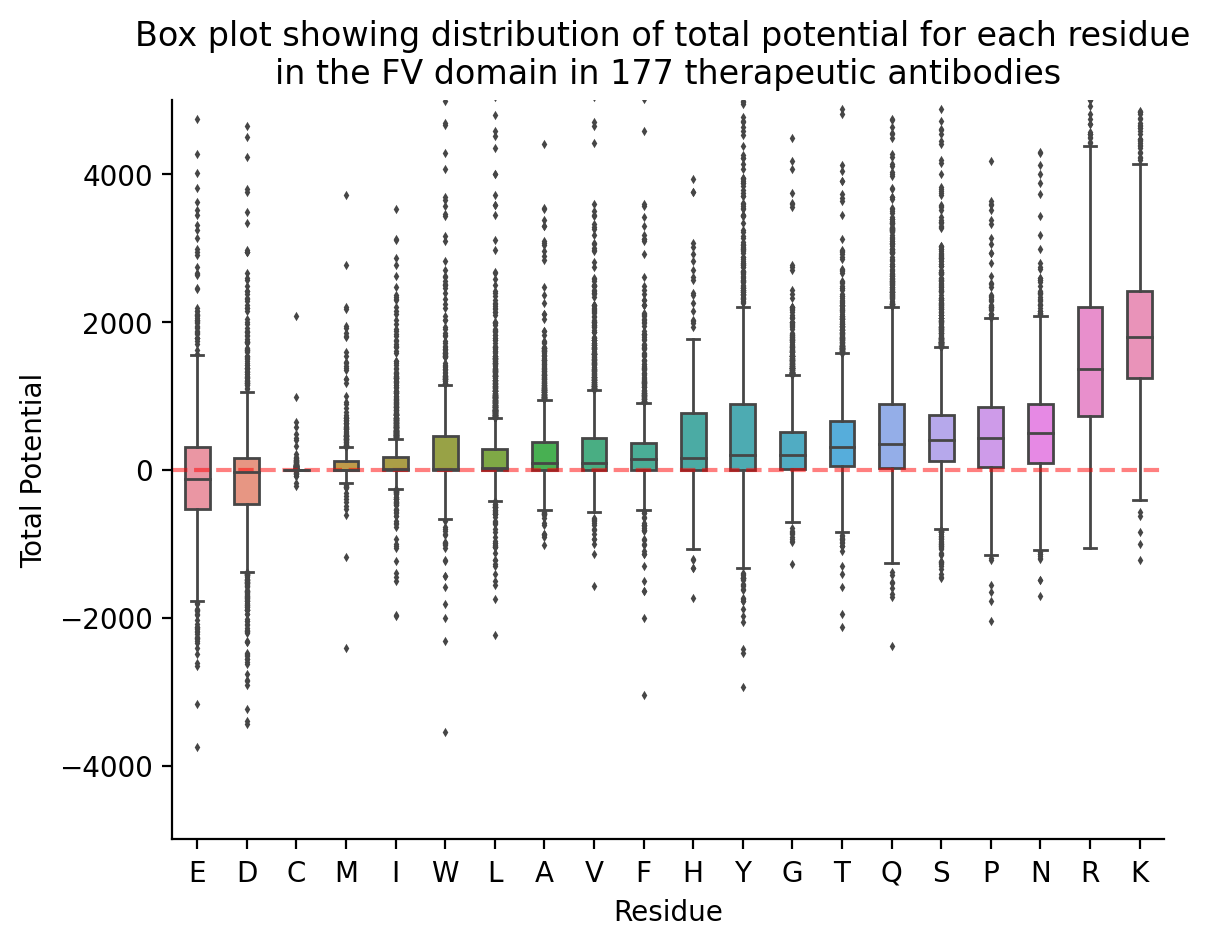

In [7]:
limit = 5000
order = tab_potentials.groupby('Residue')['total_pot'].median().sort_values().index
ax =sns.boxplot(data=tab_potentials, x='Residue', y='total_pot', order=order,linewidth=1, width=0.5,fliersize =1)
ax.axhline(0, ls='--', color='r', alpha=0.5)
ax.set(ylim=(-limit, limit), ylabel = 'Total Potential', 
       title=f'Box plot showing distribution of total potential for each residue \nin the FV domain in {len(therapeutic_ab_files)} therapeutic antibodies')
sns.despine()

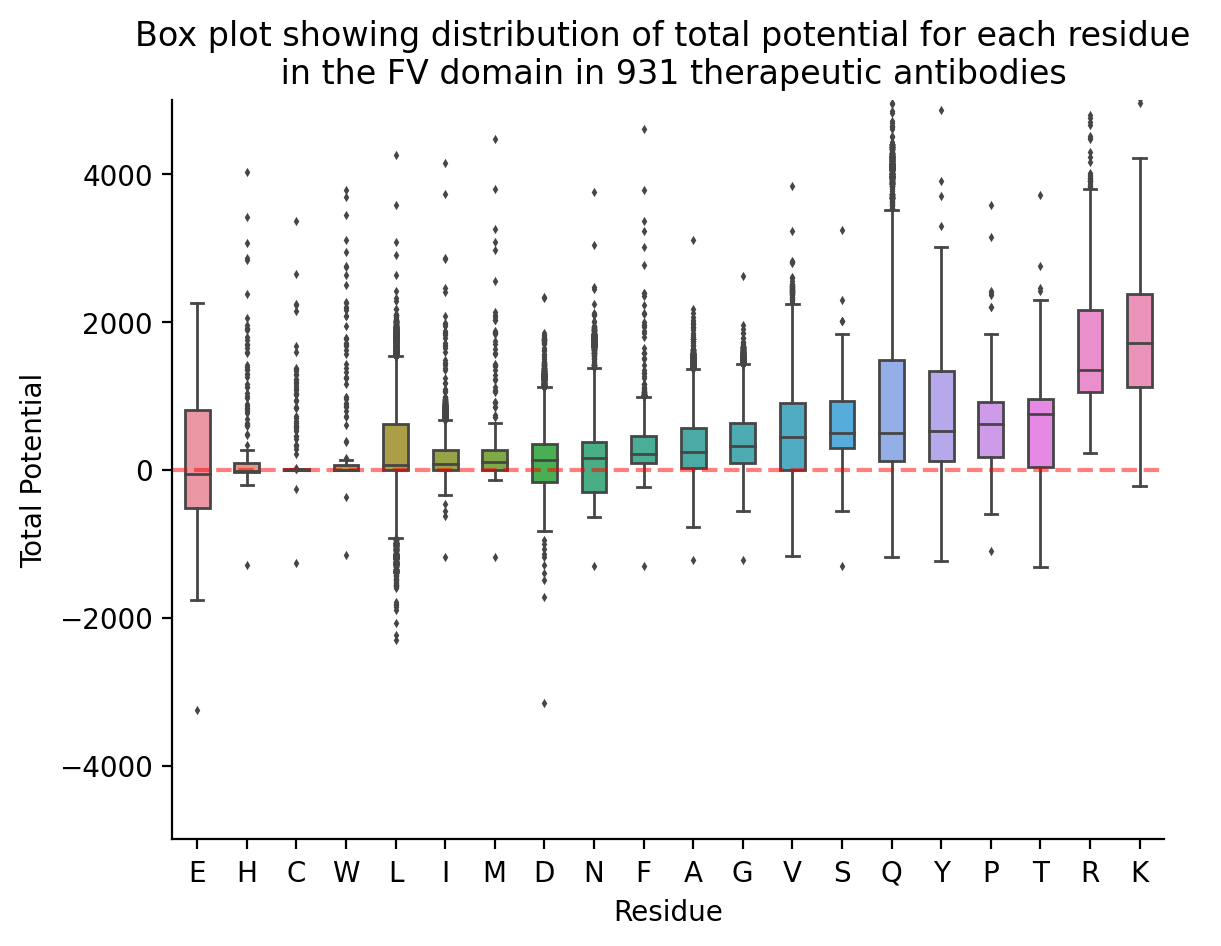

In [8]:
limit = 5000
order = mpk_potentials.groupby('Residue')['total_pot'].median().sort_values().index
ax =sns.boxplot(data=mpk_potentials, x='Residue', y='total_pot', order=order,linewidth=1, width=0.5,fliersize =1)
ax.axhline(0, ls='--', color='r', alpha=0.5)
ax.set(ylim=(-limit,limit), ylabel = 'Total Potential', 
       title=f'Box plot showing distribution of total potential for each residue \n in the FV domain in {len(mpk190_ab_files)} therapeutic antibodies')
sns.despine()


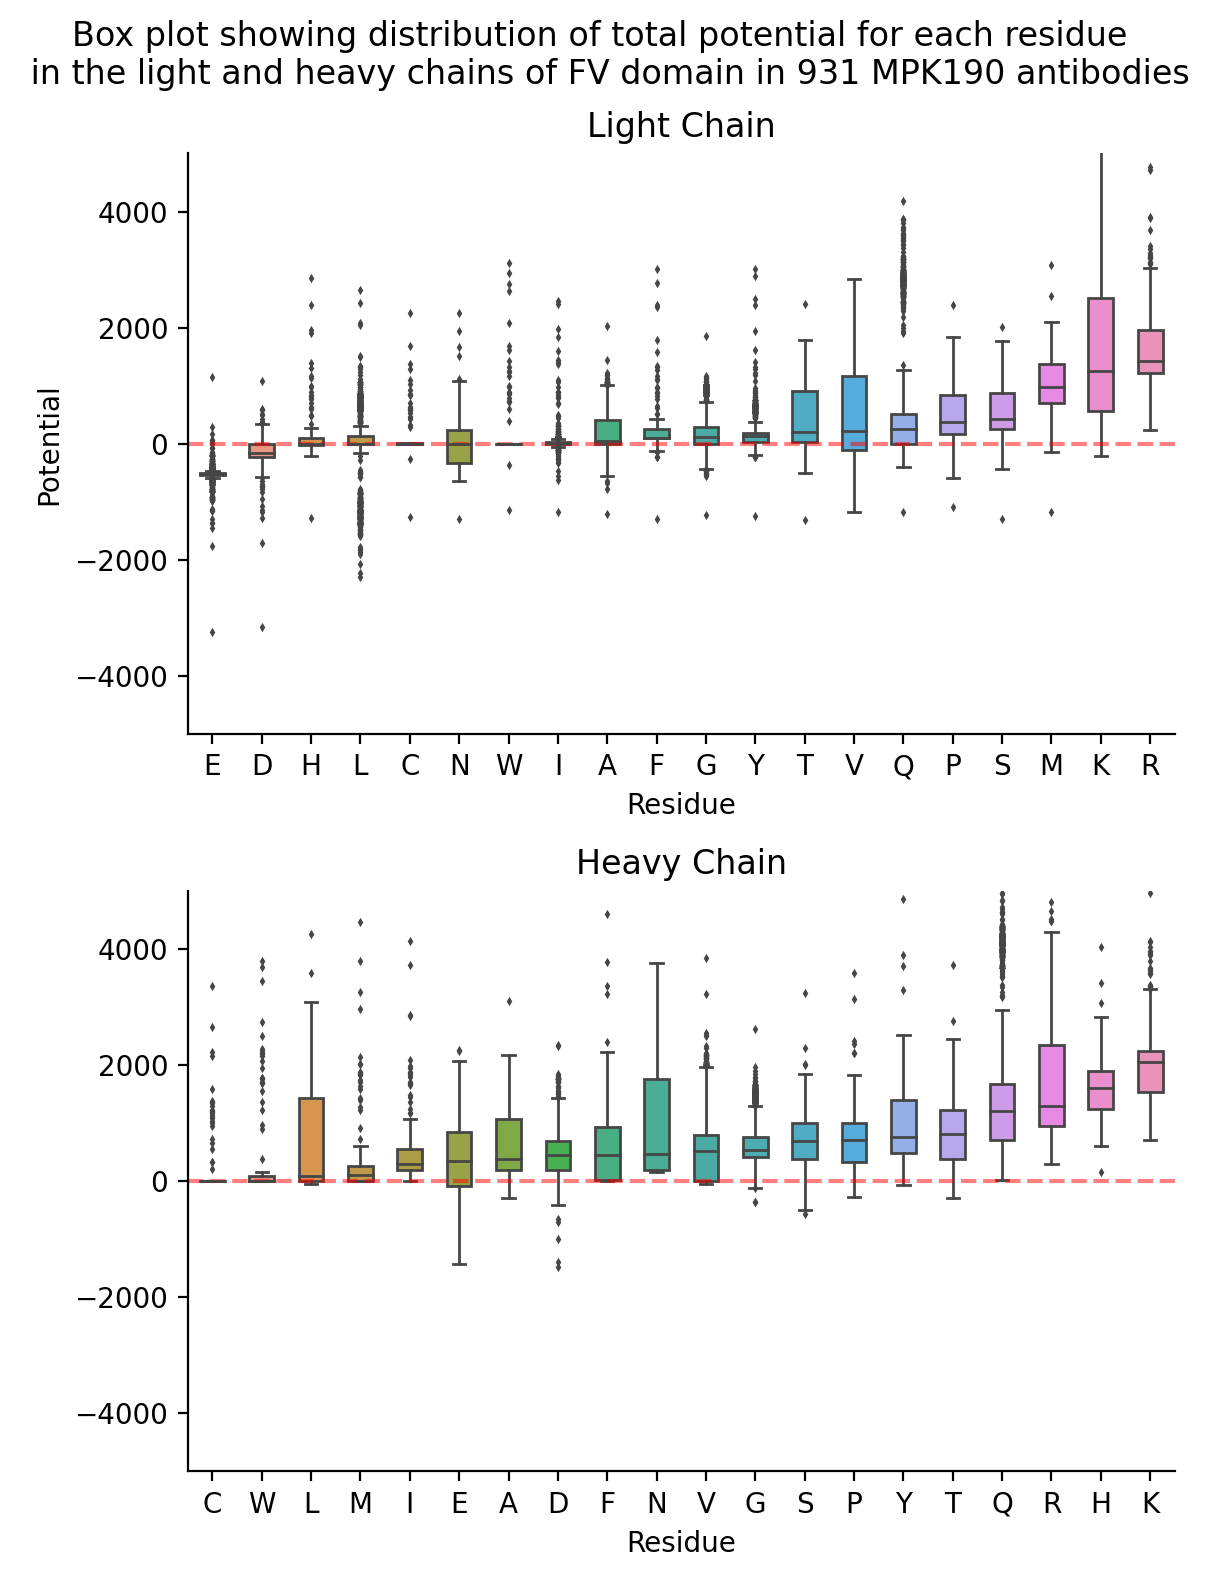

In [9]:
limit = 5000
fig, axes = plt.subplots(2,1, figsize=(6,8))
axes = np.ravel(axes)
data = mpk_potentials.query('FV_chain=="L"')
order = data.groupby('Residue')['total_pot'].median().sort_values().index
ax =sns.boxplot(data=data, x='Residue', y='total_pot', order=order,linewidth=1, width=0.5,fliersize =1, ax = axes[0])
ax.axhline(0, ls='--', color='r', alpha=0.5)
ax.set(ylim=(-limit,limit), ylabel = 'Potential', title = 'Light Chain')

data = mpk_potentials.query('FV_chain=="H"')
order = data.groupby('Residue')['total_pot'].median().sort_values().index
ax =sns.boxplot(data=data, x='Residue', y='total_pot', order=order,linewidth=1, width=0.5,fliersize =1, ax = axes[1])
ax.axhline(0, ls='--', color='r', alpha=0.5)
ax.set(ylim=(-limit,limit), ylabel ="", title = 'Heavy Chain')

sns.despine()
fig.suptitle(f'Box plot showing distribution of total potential for each residue \n in the light and heavy chains of FV domain in {len(mpk190_ab_files)} MPK190 antibodies')
plt.tight_layout()

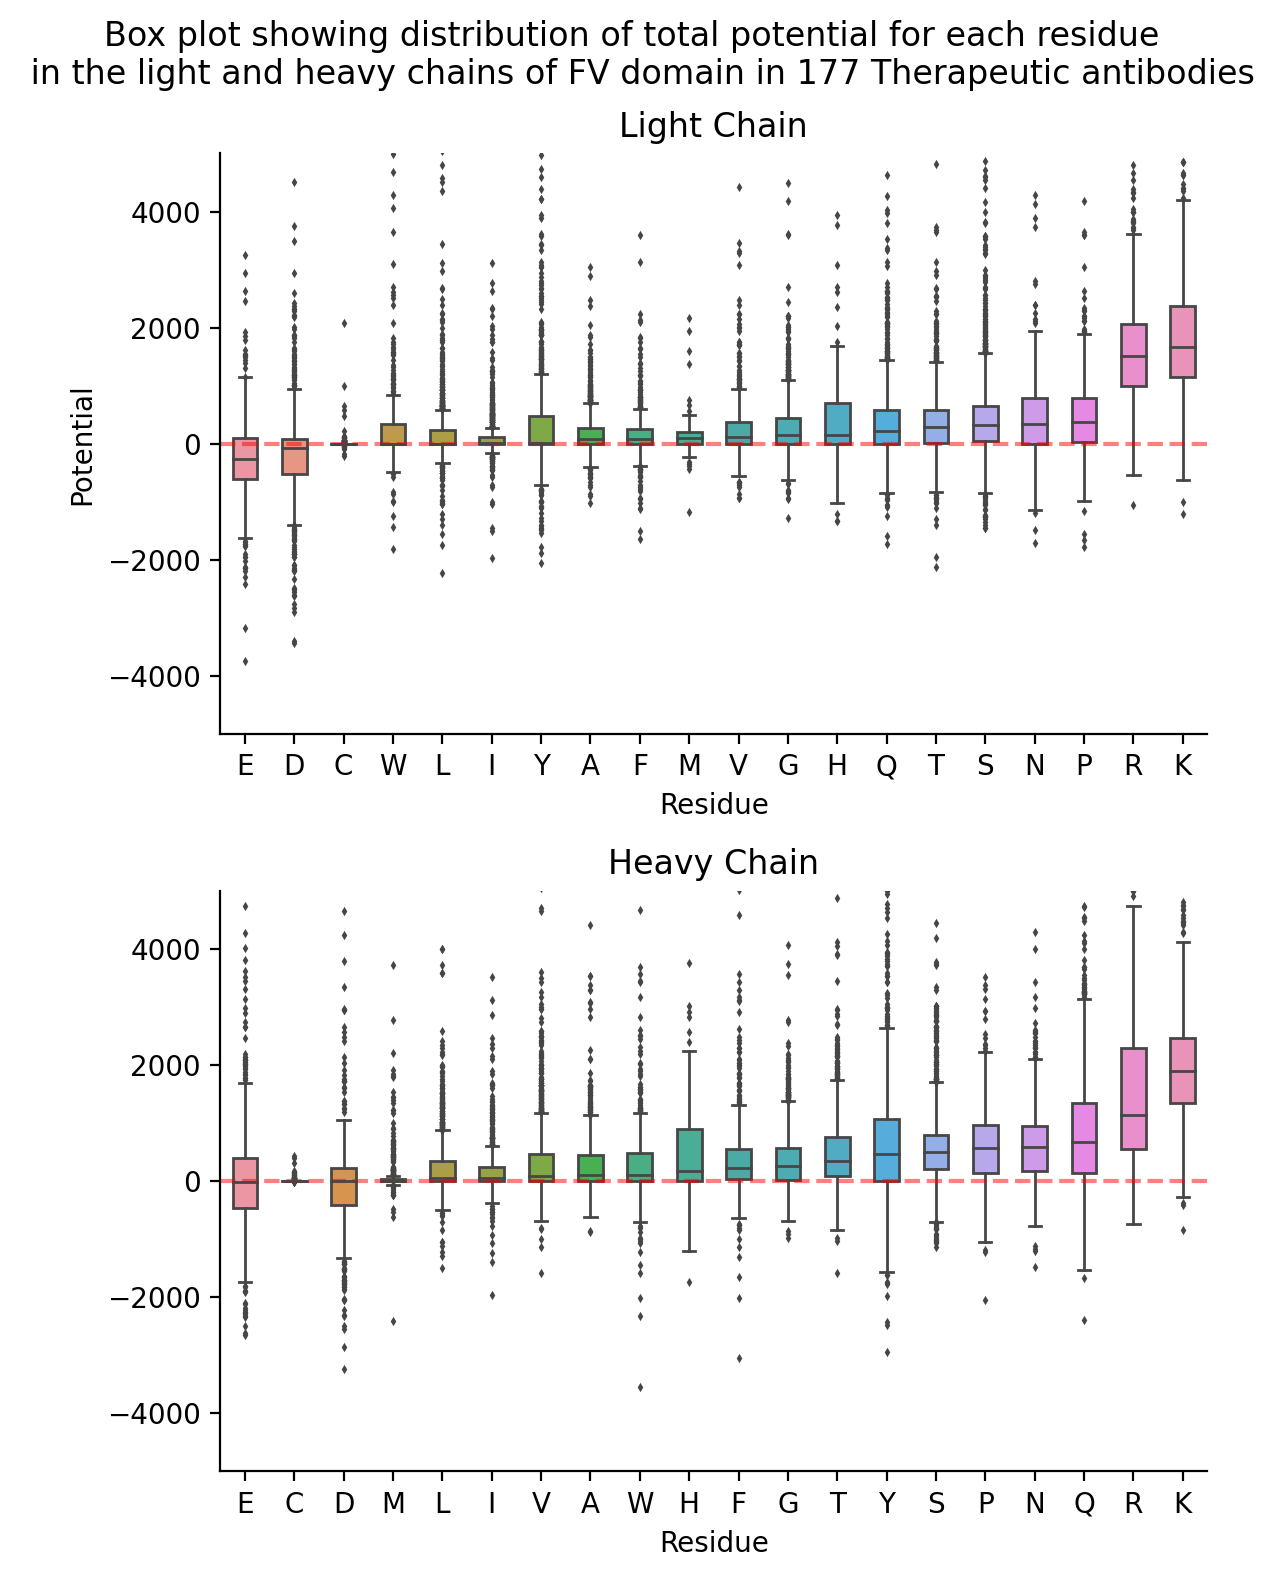

In [10]:
limit = 5000

fig, axes = plt.subplots(2,1, figsize=(6,8))
data = tab_potentials.query('FV_chain=="L"')
order = data.groupby('Residue')['total_pot'].median().sort_values().index
ax =sns.boxplot(data=data, x='Residue', y='total_pot', order=order,linewidth=1, width=0.5,fliersize =1, ax = axes[0])
ax.axhline(0, ls='--', color='r', alpha=0.5)
ax.set(ylim=(-limit,limit), ylabel = 'Potential', title = 'Light Chain')

data = tab_potentials.query('FV_chain=="H"')
order = data.groupby('Residue')['total_pot'].median().sort_values().index
ax =sns.boxplot(data=data, x='Residue', y='total_pot', order=order,linewidth=1, width=0.5,fliersize =1, ax = axes[1])
ax.axhline(0, ls='--', color='r', alpha=0.5)
ax.set(ylim=(-limit,limit), ylabel ="", title = 'Heavy Chain')

sns.despine()
fig.suptitle(f'Box plot showing distribution of total potential for each residue \n in the light and heavy chains of FV domain in {len(therapeutic_ab_files)} Therapeutic antibodies')
plt.tight_layout()

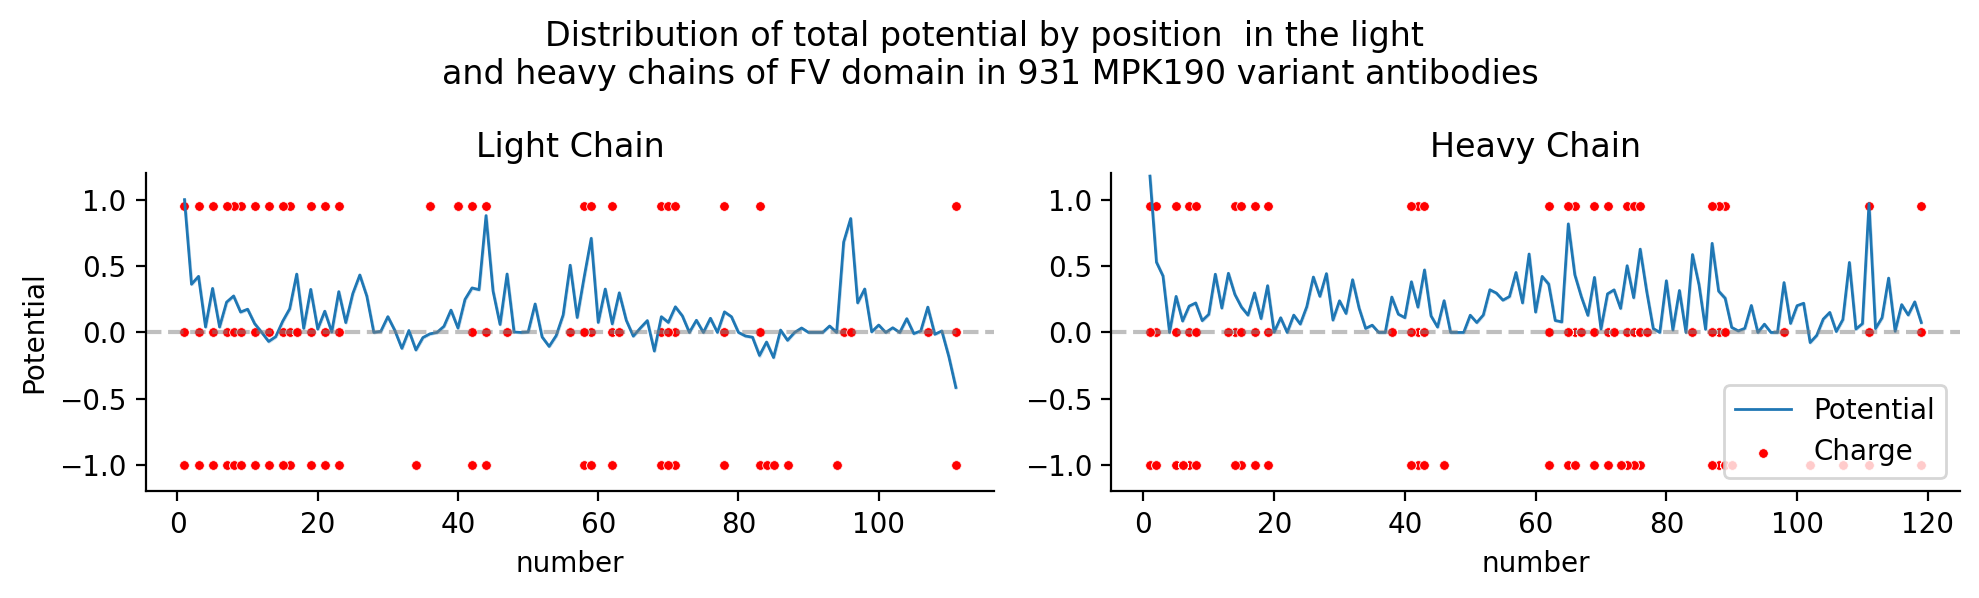

In [11]:
limit = 1.2
fig, axes = plt.subplots(1,2, figsize=(10,3))
data = mpk_potentials.query('FV_chain=="L"').copy()
data['total_pot'] = normalize_by_max_abs(data['total_pot'])

ax =sns.lineplot(data=data, x='number', y='total_pot',linewidth=1, ax = axes[0])
sns.scatterplot(data=data, x='number', y='Charge', ax = axes[0], color='r', s=12)
ax.axhline(0, ls='--', color='grey', alpha=0.5)
ax.set(ylim=(-limit,limit), ylabel = 'Potential', title = 'Light Chain')


data = mpk_potentials.query('FV_chain=="H"').copy()
data['total_pot'] = normalize_by_max_abs(data['total_pot'])
ax =sns.lineplot(data=data, x='number', y='total_pot',linewidth=1, ax = axes[1], label = 'Potential')
sns.scatterplot(data=data, x='number', y='Charge', ax = axes[1], color='r', s=12, label = 'Charge')
ax.axhline(0, ls='--', color='grey', alpha=0.5)
ax.set(ylim=(-limit,limit), ylabel ="", title = 'Heavy Chain')
ax.legend(loc=4)

sns.despine()
fig.suptitle(f'Distribution of total potential by position  in the light \nand heavy chains of FV domain in {len(mpk190_ab_files)} MPK190 variant antibodies')
plt.tight_layout()

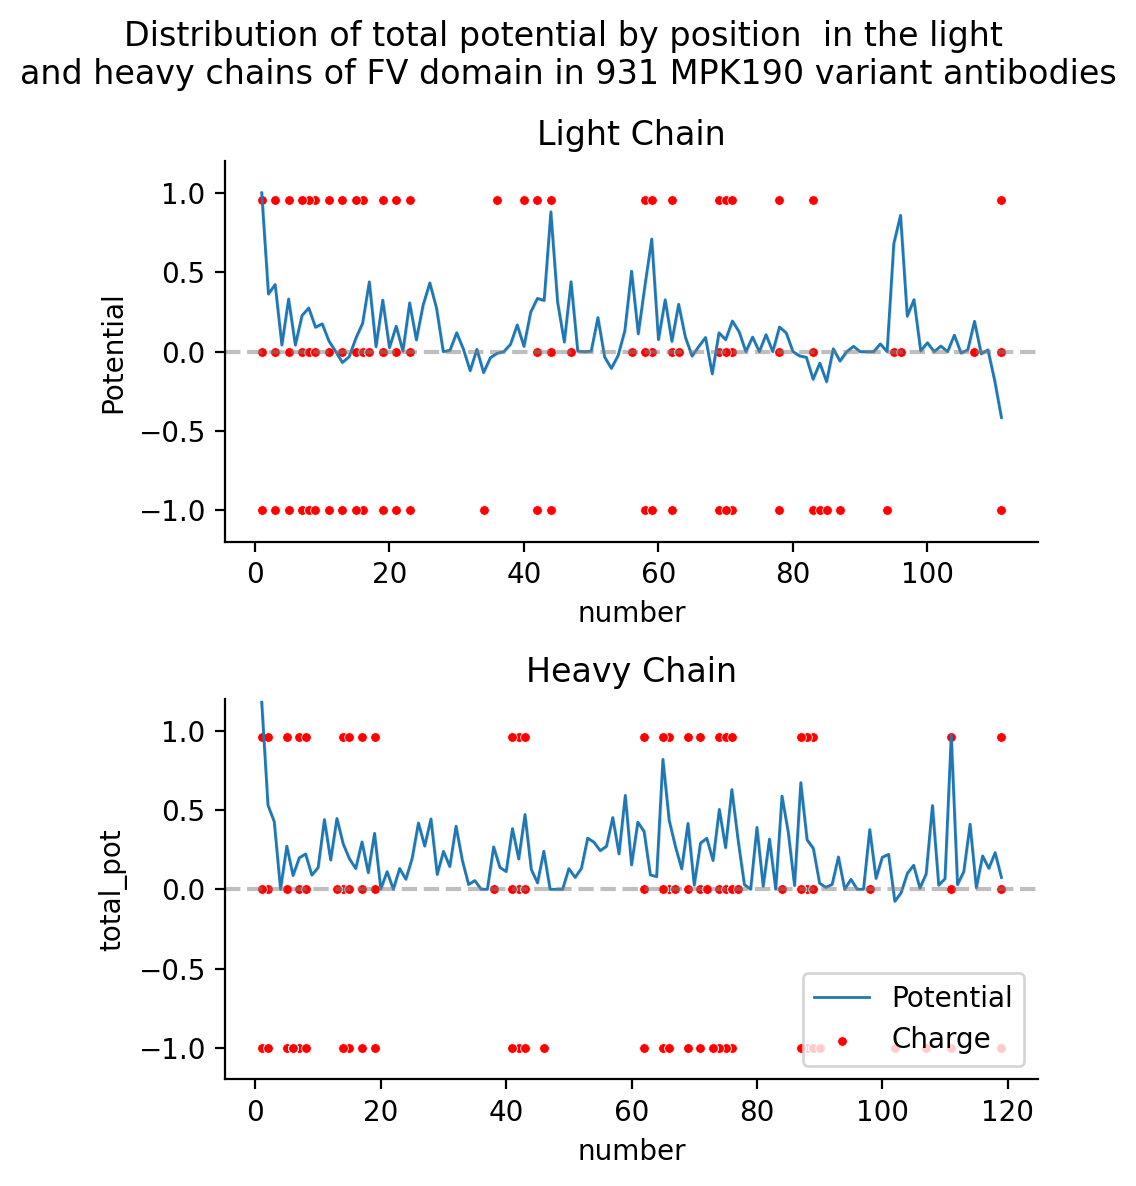

In [12]:
limit = 1.2
fig, axes = plt.subplots(2,1, figsize=(5,6))
axes = np.ravel(axes)
data = mpk_potentials.query('FV_chain=="L"').copy()
data['total_pot'] = normalize_by_max_abs(data['total_pot'])

ax =sns.lineplot(data=data, x='number', y='total_pot',linewidth=1, ax = axes[0])
sns.scatterplot(data=data, x='number', y='Charge', ax = axes[0], color='r', s=12)
ax.axhline(0, ls='--', color='grey', alpha=0.5)
ax.set(ylim=(-limit,limit), ylabel = 'Potential', title = 'Light Chain')


data = mpk_potentials.query('FV_chain=="H"').copy()
data['total_pot'] = normalize_by_max_abs(data['total_pot'])
ax =sns.lineplot(data=data, x='number', y='total_pot',linewidth=1, ax = axes[1], label = 'Potential')
sns.scatterplot(data=data, x='number', y='Charge', ax = axes[1], color='r', s=12, label = 'Charge')
ax.axhline(0, ls='--', color='grey', alpha=0.5)
ax.set(ylim=(-limit,limit), title = 'Heavy Chain')
ax.legend(loc=4)

sns.despine()
fig.suptitle(f'Distribution of total potential by position  in the light \nand heavy chains of FV domain in {len(mpk190_ab_files)} MPK190 variant antibodies')
plt.tight_layout()

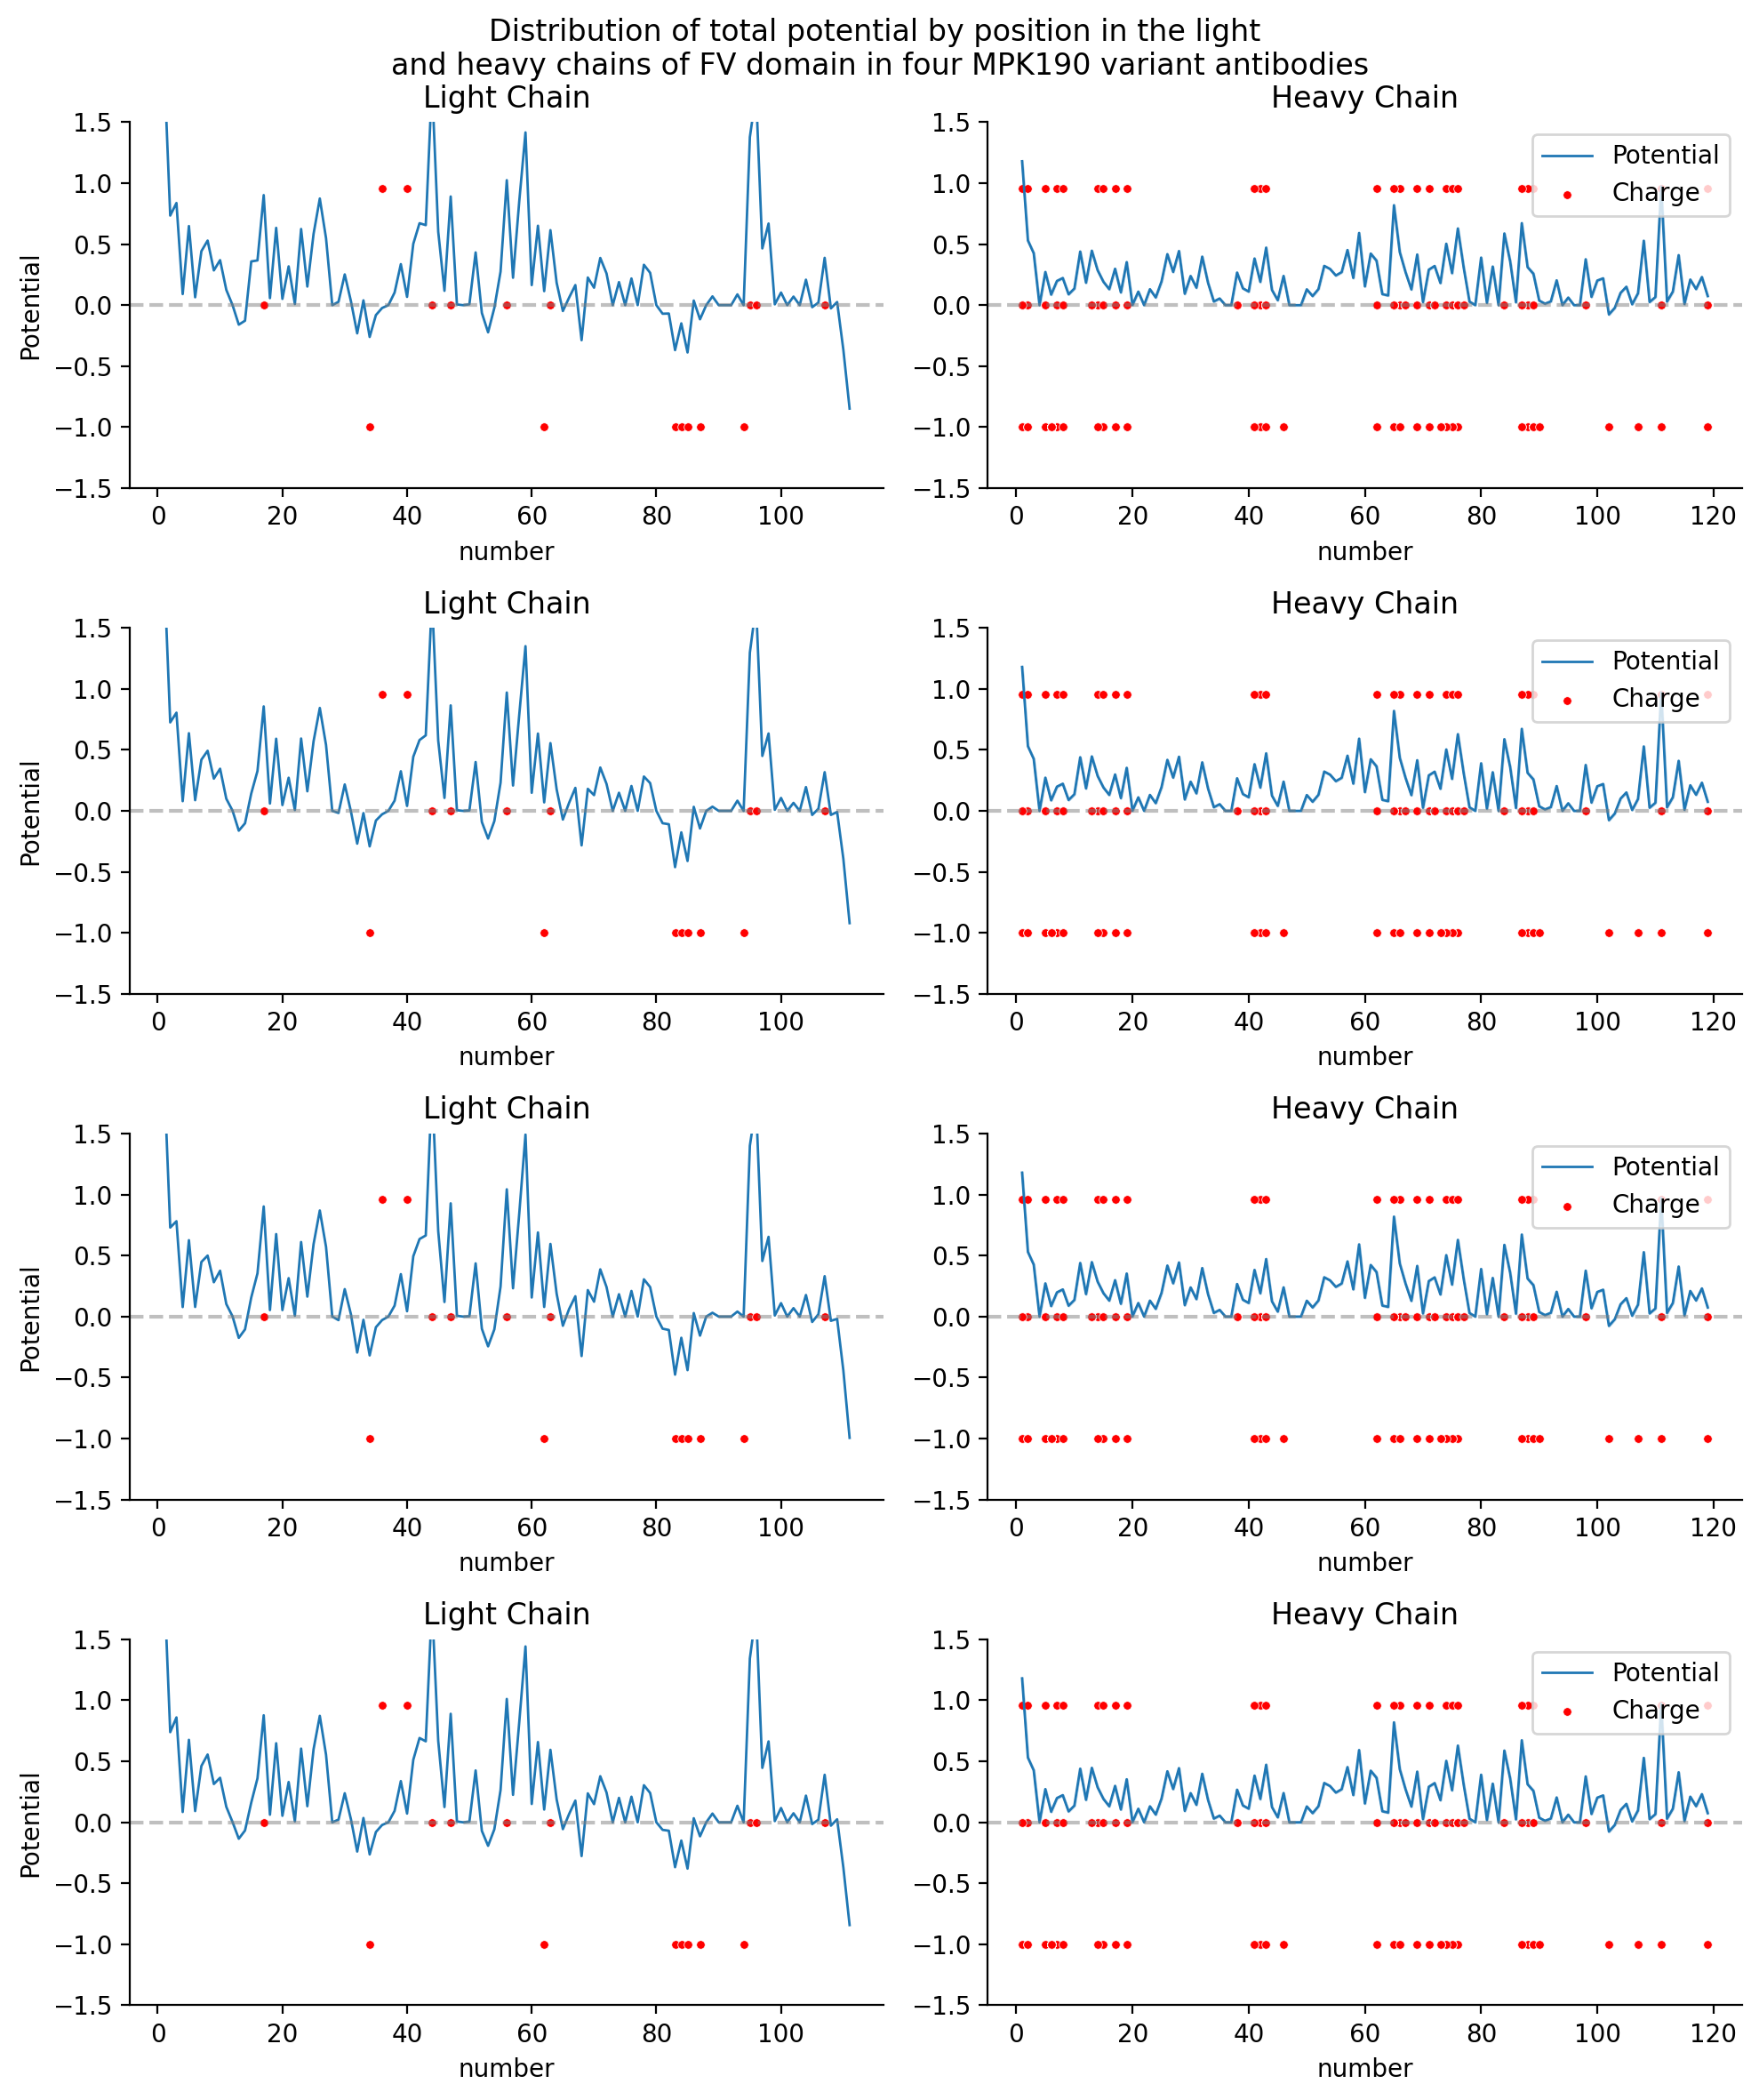

In [13]:
sampled_abs = pd.Series(mpk_potentials.name.unique()).sample(4, random_state=42)
names = list(sampled_abs.values)

limit = 1.5
fig, axes = plt.subplots(4,2, figsize=(10,12))
axes = np.ravel(axes)
for i in range(4): 
    name = names[i]
    data = mpk_potentials.query('FV_chain=="L" and name ==@name').copy()
    data['total_pot'] = normalize_by_max_abs(data['total_pot'])

    ax =sns.lineplot(data=data, x='number', y='total_pot',linewidth=1, ax = axes[i*2])
    sns.scatterplot(data=data, x='number', y='Charge', ax = axes[i*2], color='r', s=12)
    ax.axhline(0, ls='--', color='grey', alpha=0.5)
    ax.set(ylim=(-limit,limit), ylabel = 'Potential', title = 'Light Chain')


    data = mpk_potentials.query('FV_chain=="H" and name ==name').copy()
    data['total_pot'] = normalize_by_max_abs(data['total_pot'])
    ax =sns.lineplot(data=data, x='number', y='total_pot',linewidth=1, ax = axes[i*2 +1], label = 'Potential')
    sns.scatterplot(data=data, x='number', y='Charge', ax = axes[i*2 +1], color='r', s=12, label = 'Charge')
    ax.axhline(0, ls='--', color='grey', alpha=0.5)
    ax.set(ylim=(-limit,limit), ylabel ="", title = 'Heavy Chain')


sns.despine()
fig.suptitle(f'Distribution of total potential by position in the light \nand heavy chains of FV domain in four MPK190 variant antibodies')
plt.tight_layout()

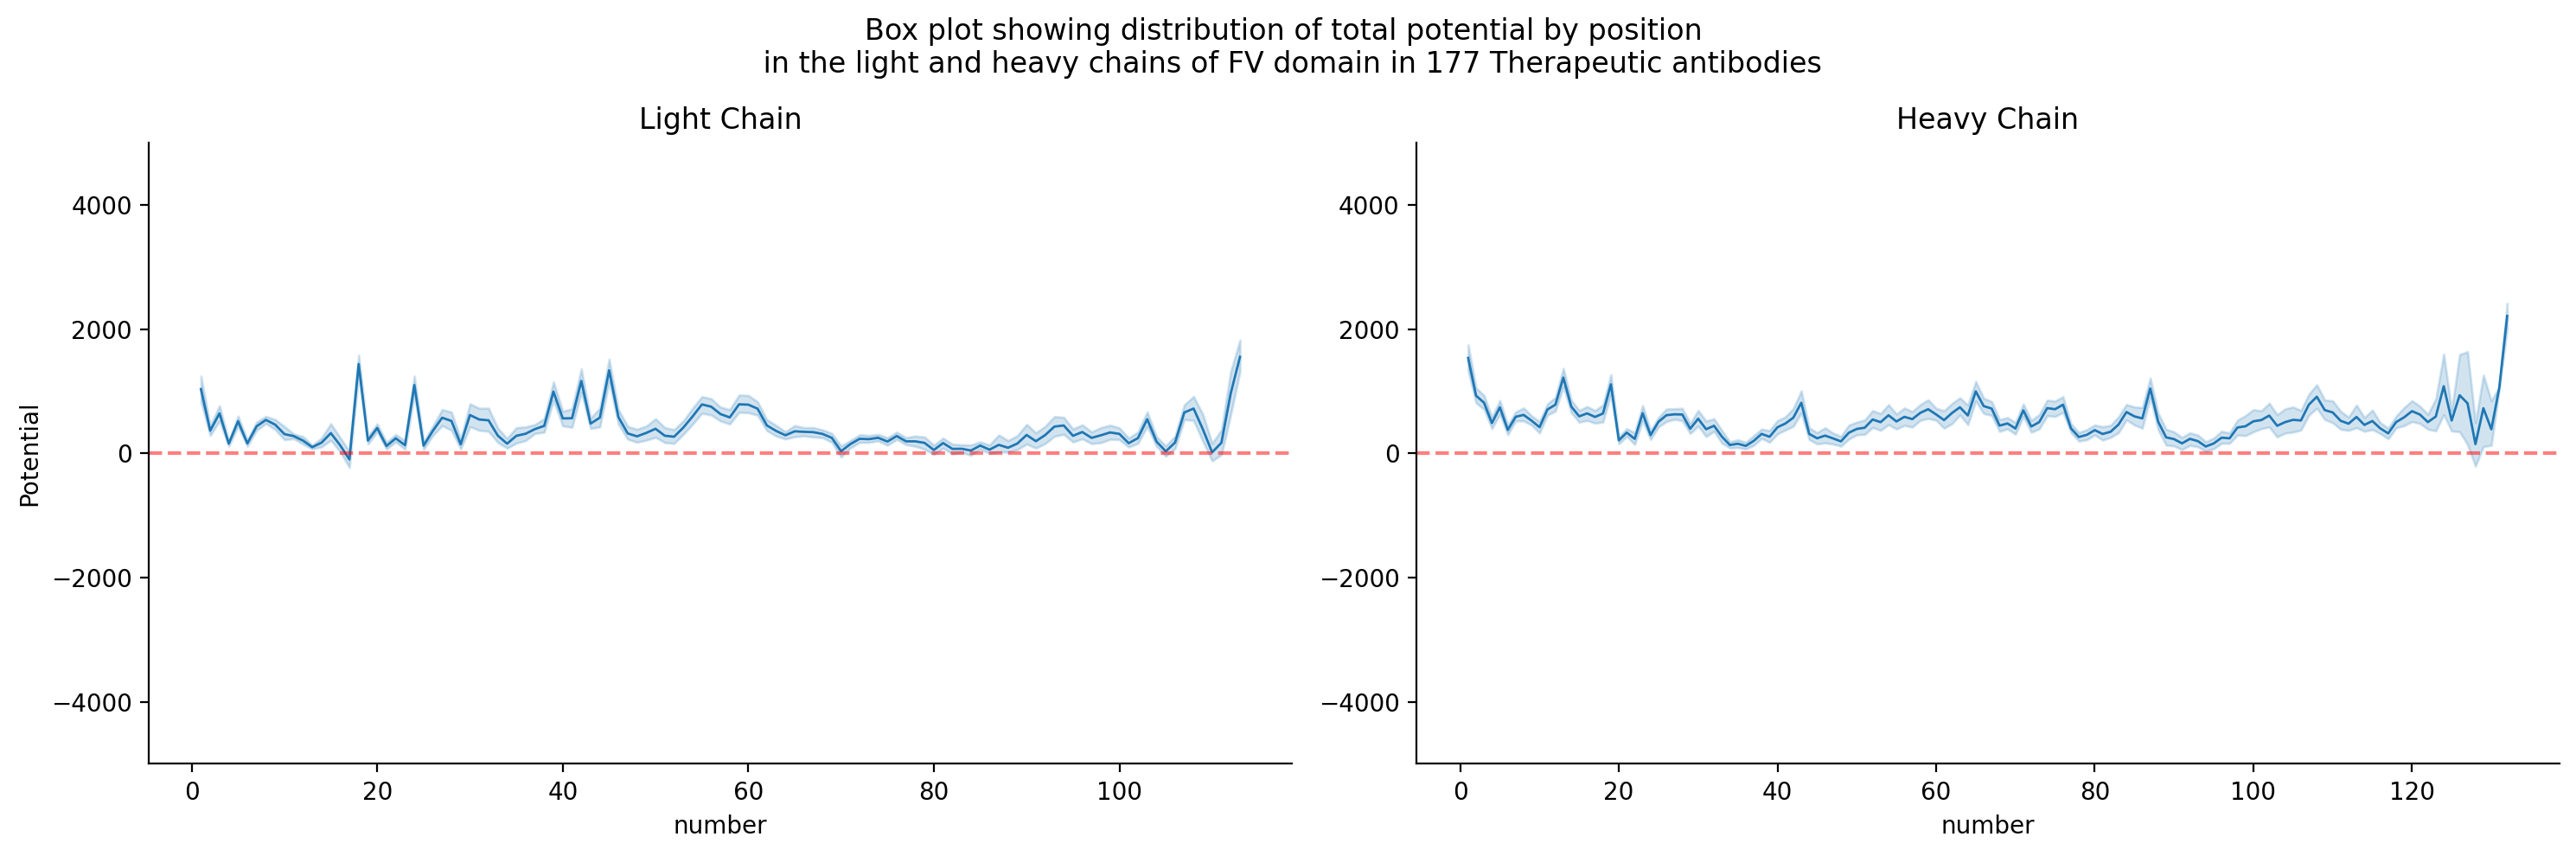

In [14]:
limit = 5000
fig, axes = plt.subplots(1,2, figsize=(15,5))
data = tab_potentials.query('FV_chain=="L" and FV_region!="NonFV"').copy()

ax =sns.lineplot(data=data, x='number', y='total_pot',linewidth=1, ax = axes[0])
ax.axhline(0, ls='--', color='r', alpha=0.5)
ax.set(ylim=(-limit,limit), ylabel = 'Potential', title = 'Light Chain')

data = tab_potentials.query('FV_chain=="H" and FV_region!="NonFV"').copy()
ax =sns.lineplot(data=data, x='number', y='total_pot',linewidth=1, ax = axes[1])
ax.axhline(0, ls='--', color='r', alpha=0.5)
ax.set(ylim=(-limit,limit), ylabel ="", title = 'Heavy Chain')

sns.despine()
n_abs = len(tab_potentials.name.unique())
fig.suptitle(f'Box plot showing distribution of total potential by position \n in the light and heavy chains of FV domain in {n_abs} Therapeutic antibodies')
plt.tight_layout()

In [15]:
names

['MPK190-L-G15Q-V48L-H-A49S-T77K-I101Y',
 'MPK190-L-V48L-H-G8D-A49S-T77K-I101Y',
 'MPK190-L-V48L-H-A49S-T77K-R87H-I101Y',
 'MPK190-L-V48L-H-A49S-G66F-T77K-I101Y']

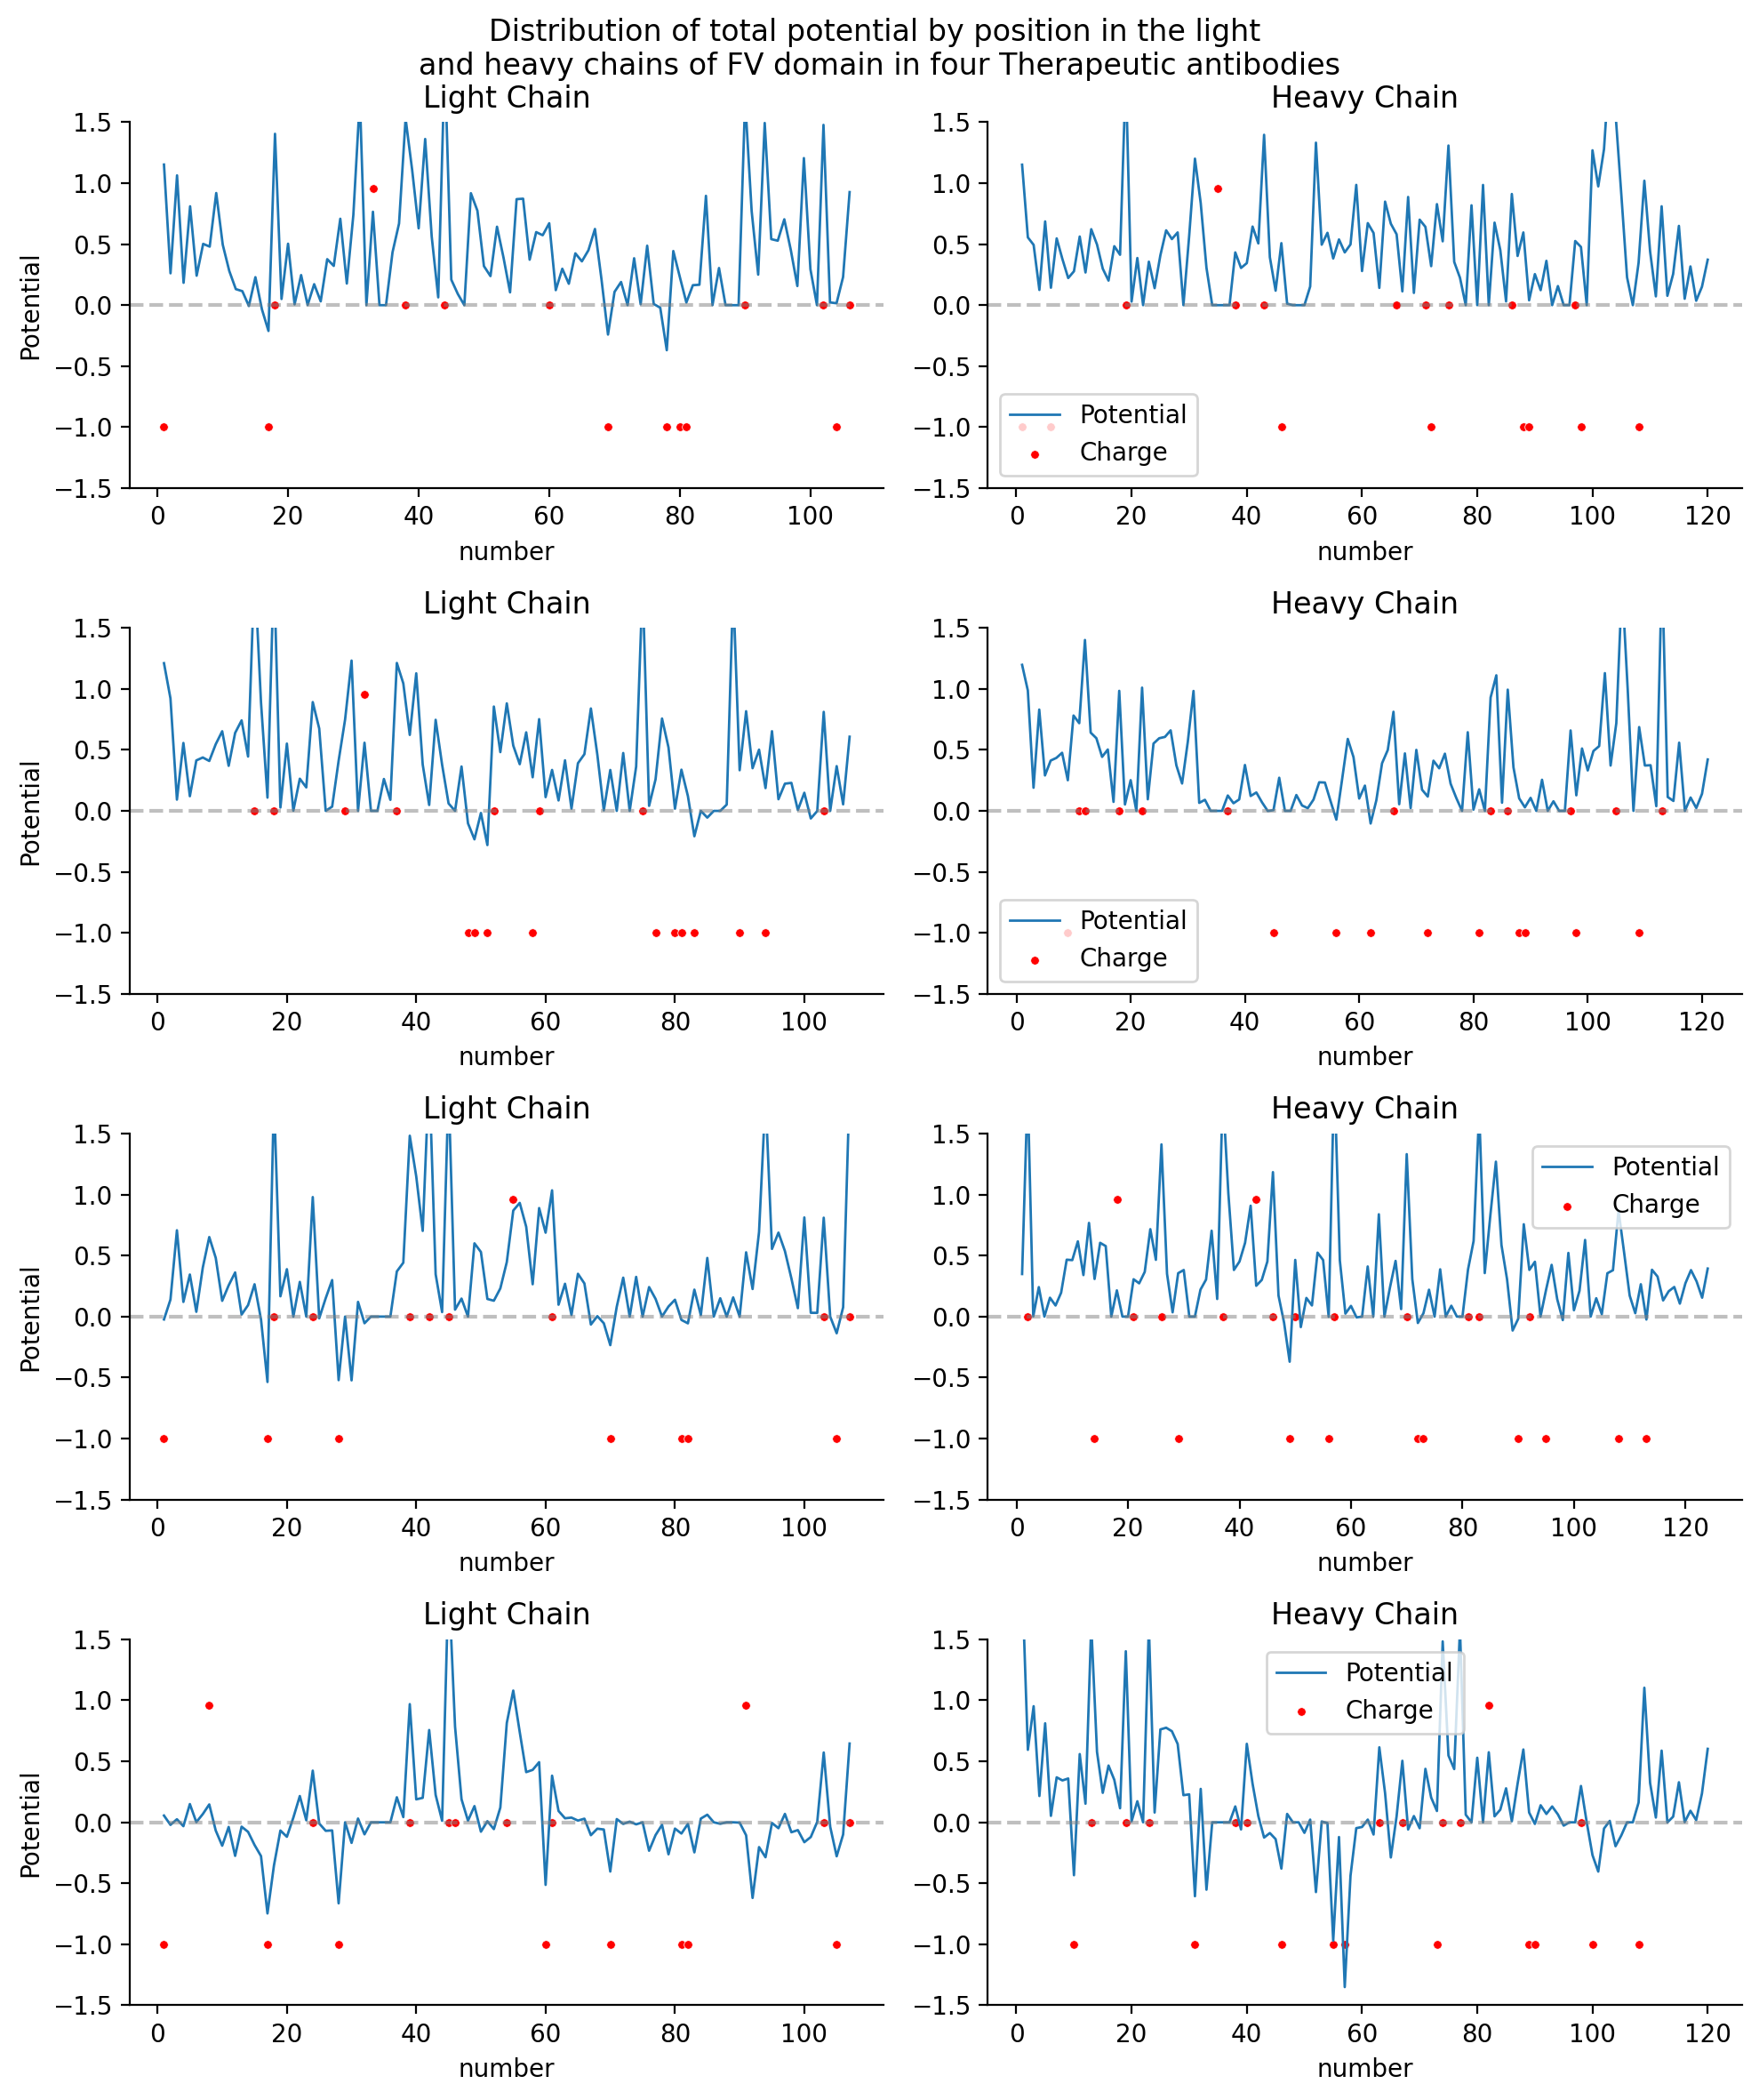

In [16]:
sampled_abs = pd.Series(tab_potentials.name.unique()).sample(4, random_state=42)
names = list(sampled_abs.values)

limit = 1.5
fig, axes = plt.subplots(4,2, figsize=(10,12))
axes = np.ravel(axes)
for i in range(4): 
    name = names[i]
    data = tab_potentials.query('FV_chain=="L" and name ==@name').copy()
    data['total_pot'] = normalize_by_max_abs(data['total_pot'])

    ax =sns.lineplot(data=data, x='number', y='total_pot',linewidth=1, ax = axes[i*2])
    sns.scatterplot(data=data, x='number', y='Charge', ax = axes[i*2], color='r', s=12)
    ax.axhline(0, ls='--', color='grey', alpha=0.5)
    ax.set(ylim=(-limit,limit), ylabel = 'Potential', title = 'Light Chain')


    data = tab_potentials.query('FV_chain=="H" and name ==@name').copy()
    data['total_pot'] = normalize_by_max_abs(data['total_pot'])
    ax =sns.lineplot(data=data, x='number', y='total_pot',linewidth=1, ax = axes[i*2 +1], label = 'Potential')
    sns.scatterplot(data=data, x='number', y='Charge', ax = axes[i*2 +1], color='r', s=12, label = 'Charge')
    ax.axhline(0, ls='--', color='grey', alpha=0.5)
    ax.set(ylim=(-limit,limit), ylabel ="", title = 'Heavy Chain')


sns.despine()
fig.suptitle(f'Distribution of total potential by position in the light \nand heavy chains of FV domain in four Therapeutic antibodies')
plt.tight_layout()

In [17]:
lc_data = mpk_potentials.query('FV_chain=="L"').copy()
lc_charge_potential_correlations = pd.DataFrame(lc_data.dropna().groupby(['name'])[['total_pot', 'Charge']].apply(lambda x: x.corr().iloc[1,0]))
lc_data[['total_pot', 'Charge']].dropna().corr()


total_pot    Charge
total_pot   1.000000  0.443418
Charge      0.443418  1.000000

In [18]:
hc_data = mpk_potentials.query('FV_chain=="H"').copy()
hc_charge_potential_correlations = pd.DataFrame(hc_data.dropna().groupby(['name'])[['total_pot', 'Charge']].apply(lambda x: x.corr().iloc[1,0]))
hc_data[['total_pot', 'Charge']].dropna().corr()

total_pot    Charge
total_pot   1.000000  0.678224
Charge      0.678224  1.000000

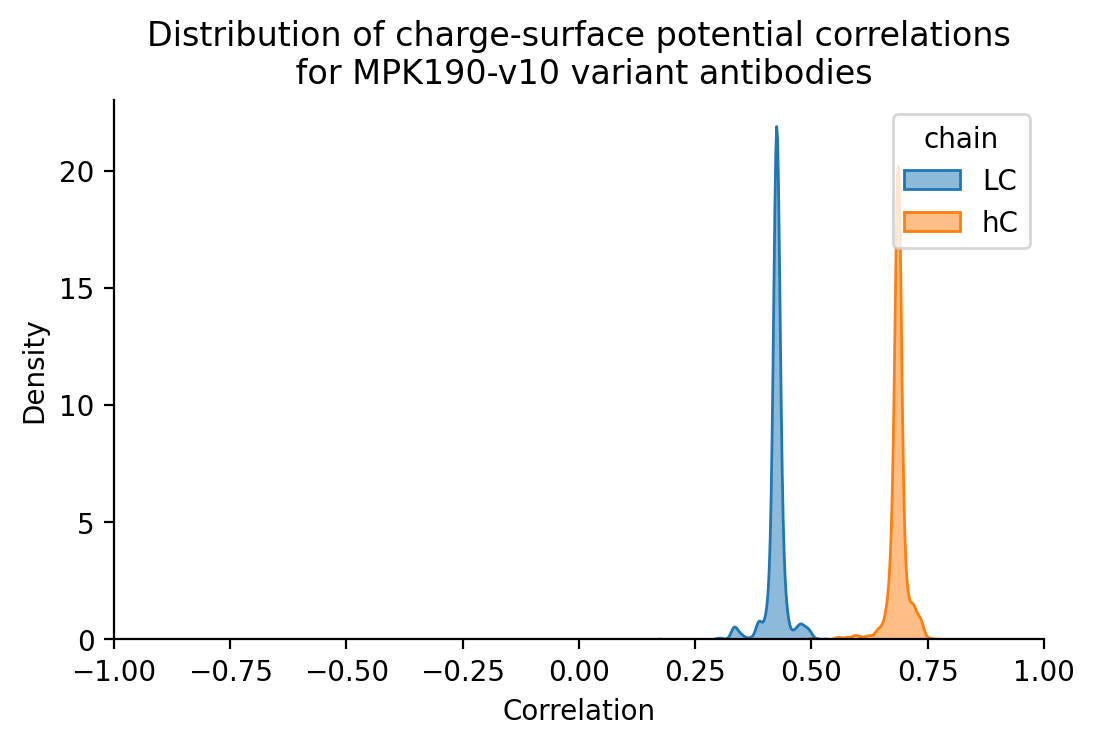

In [19]:


lc_charge_potential_correlations['chain'] = 'LC'
hc_charge_potential_correlations['chain'] = 'hC'
charge_potential_correlations = pd.concat([lc_charge_potential_correlations, hc_charge_potential_correlations])
charge_potential_correlations.columns = ['correlation', 'chain']
fig  =plt.figure(figsize=(6,3.5))
ax = sns.kdeplot(data=charge_potential_correlations, x='correlation', hue='chain', fill=True, alpha=0.5)
ax.set(xlim=(-1,1), xlabel='Correlation', ylabel='Density', title='Distribution of charge-surface potential correlations\n for MPK190-v10 variant antibodies')
sns.despine()


### Make the above plot for the therapeutic antibodies

In [20]:
tab_lc_data = tab_potentials.query('FV_chain=="L"').copy()
tab_lc_charge_potential_correlations = pd.DataFrame(tab_lc_data.dropna().groupby(['name'])[['total_pot', 'Charge']].apply(lambda x: x.corr().iloc[1,0]))
tab_lc_data[['total_pot', 'Charge']].dropna().corr()


total_pot   Charge
total_pot    1.00000  0.55947
Charge       0.55947  1.00000

In [21]:
tab_hc_data = tab_potentials.query('FV_chain=="H"').copy()
tab_hc_charge_potential_correlations = pd.DataFrame(tab_hc_data.dropna().groupby(['name'])[['total_pot', 'Charge']].apply(lambda x: x.corr().iloc[1,0]))
tab_hc_data[['total_pot', 'Charge']].dropna().corr()

total_pot    Charge
total_pot   1.000000  0.536015
Charge      0.536015  1.000000

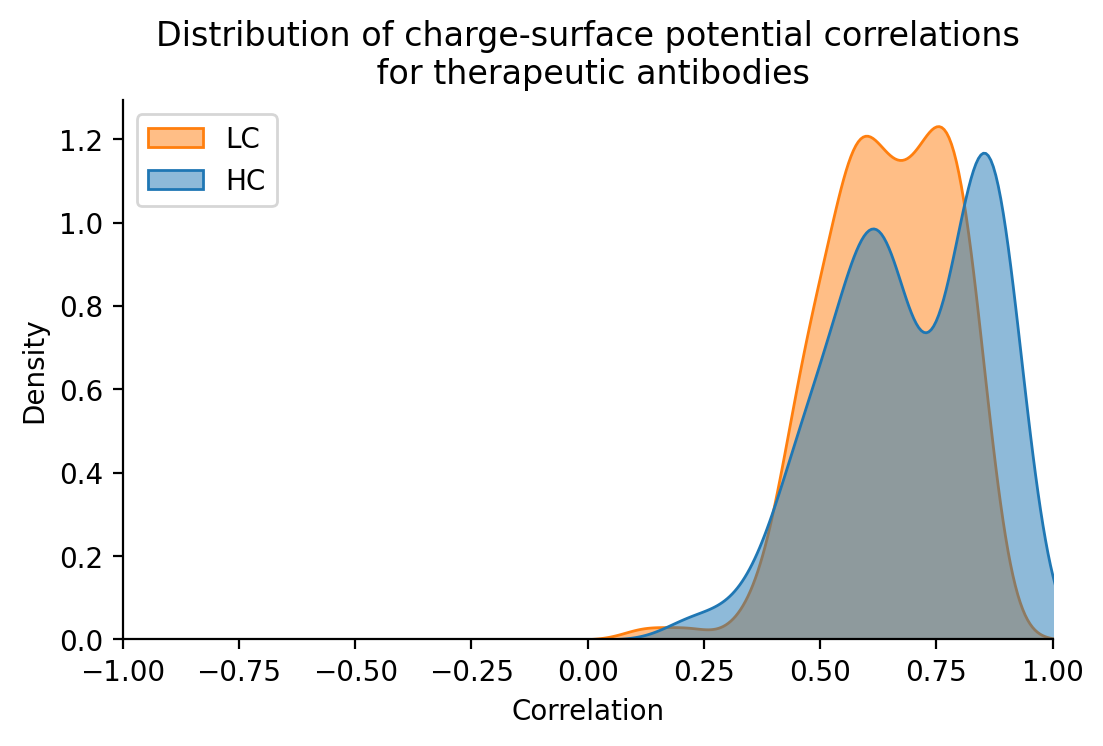

In [22]:
tab_lc_charge_potential_correlations['chain'] = 'LC'
tab_hc_charge_potential_correlations['chain'] = 'hC'
tab_charge_potential_correlations = pd.concat([tab_lc_charge_potential_correlations, tab_hc_charge_potential_correlations])
tab_charge_potential_correlations.columns = ['correlation', 'chain']
fig  =plt.figure(figsize=(6,3.5))
ax = sns.kdeplot(data=tab_charge_potential_correlations, x='correlation', hue='chain', fill=True, alpha=0.5)
ax.set(xlim=(-1,1), xlabel='Correlation', ylabel='Density', 
       title='Distribution of charge-surface potential correlations\n for therapeutic antibodies')
ax.legend(labels= ['LC', 'HC'], loc=2)
       

sns.despine()


#### Correlograms of charges 

In [23]:
tab_region_charges = pd.concat([calculate_descriptors_on_charges(df,name) for name, df in tab_charges.items()])
mpk190_region_charges = pd.concat([calculate_descriptors_on_charges(df,name) for name, df in mpk_charges.items()])

<Axes: title={'center': 'Correlogram of charge descriptors for therapeutic antibodies'}>

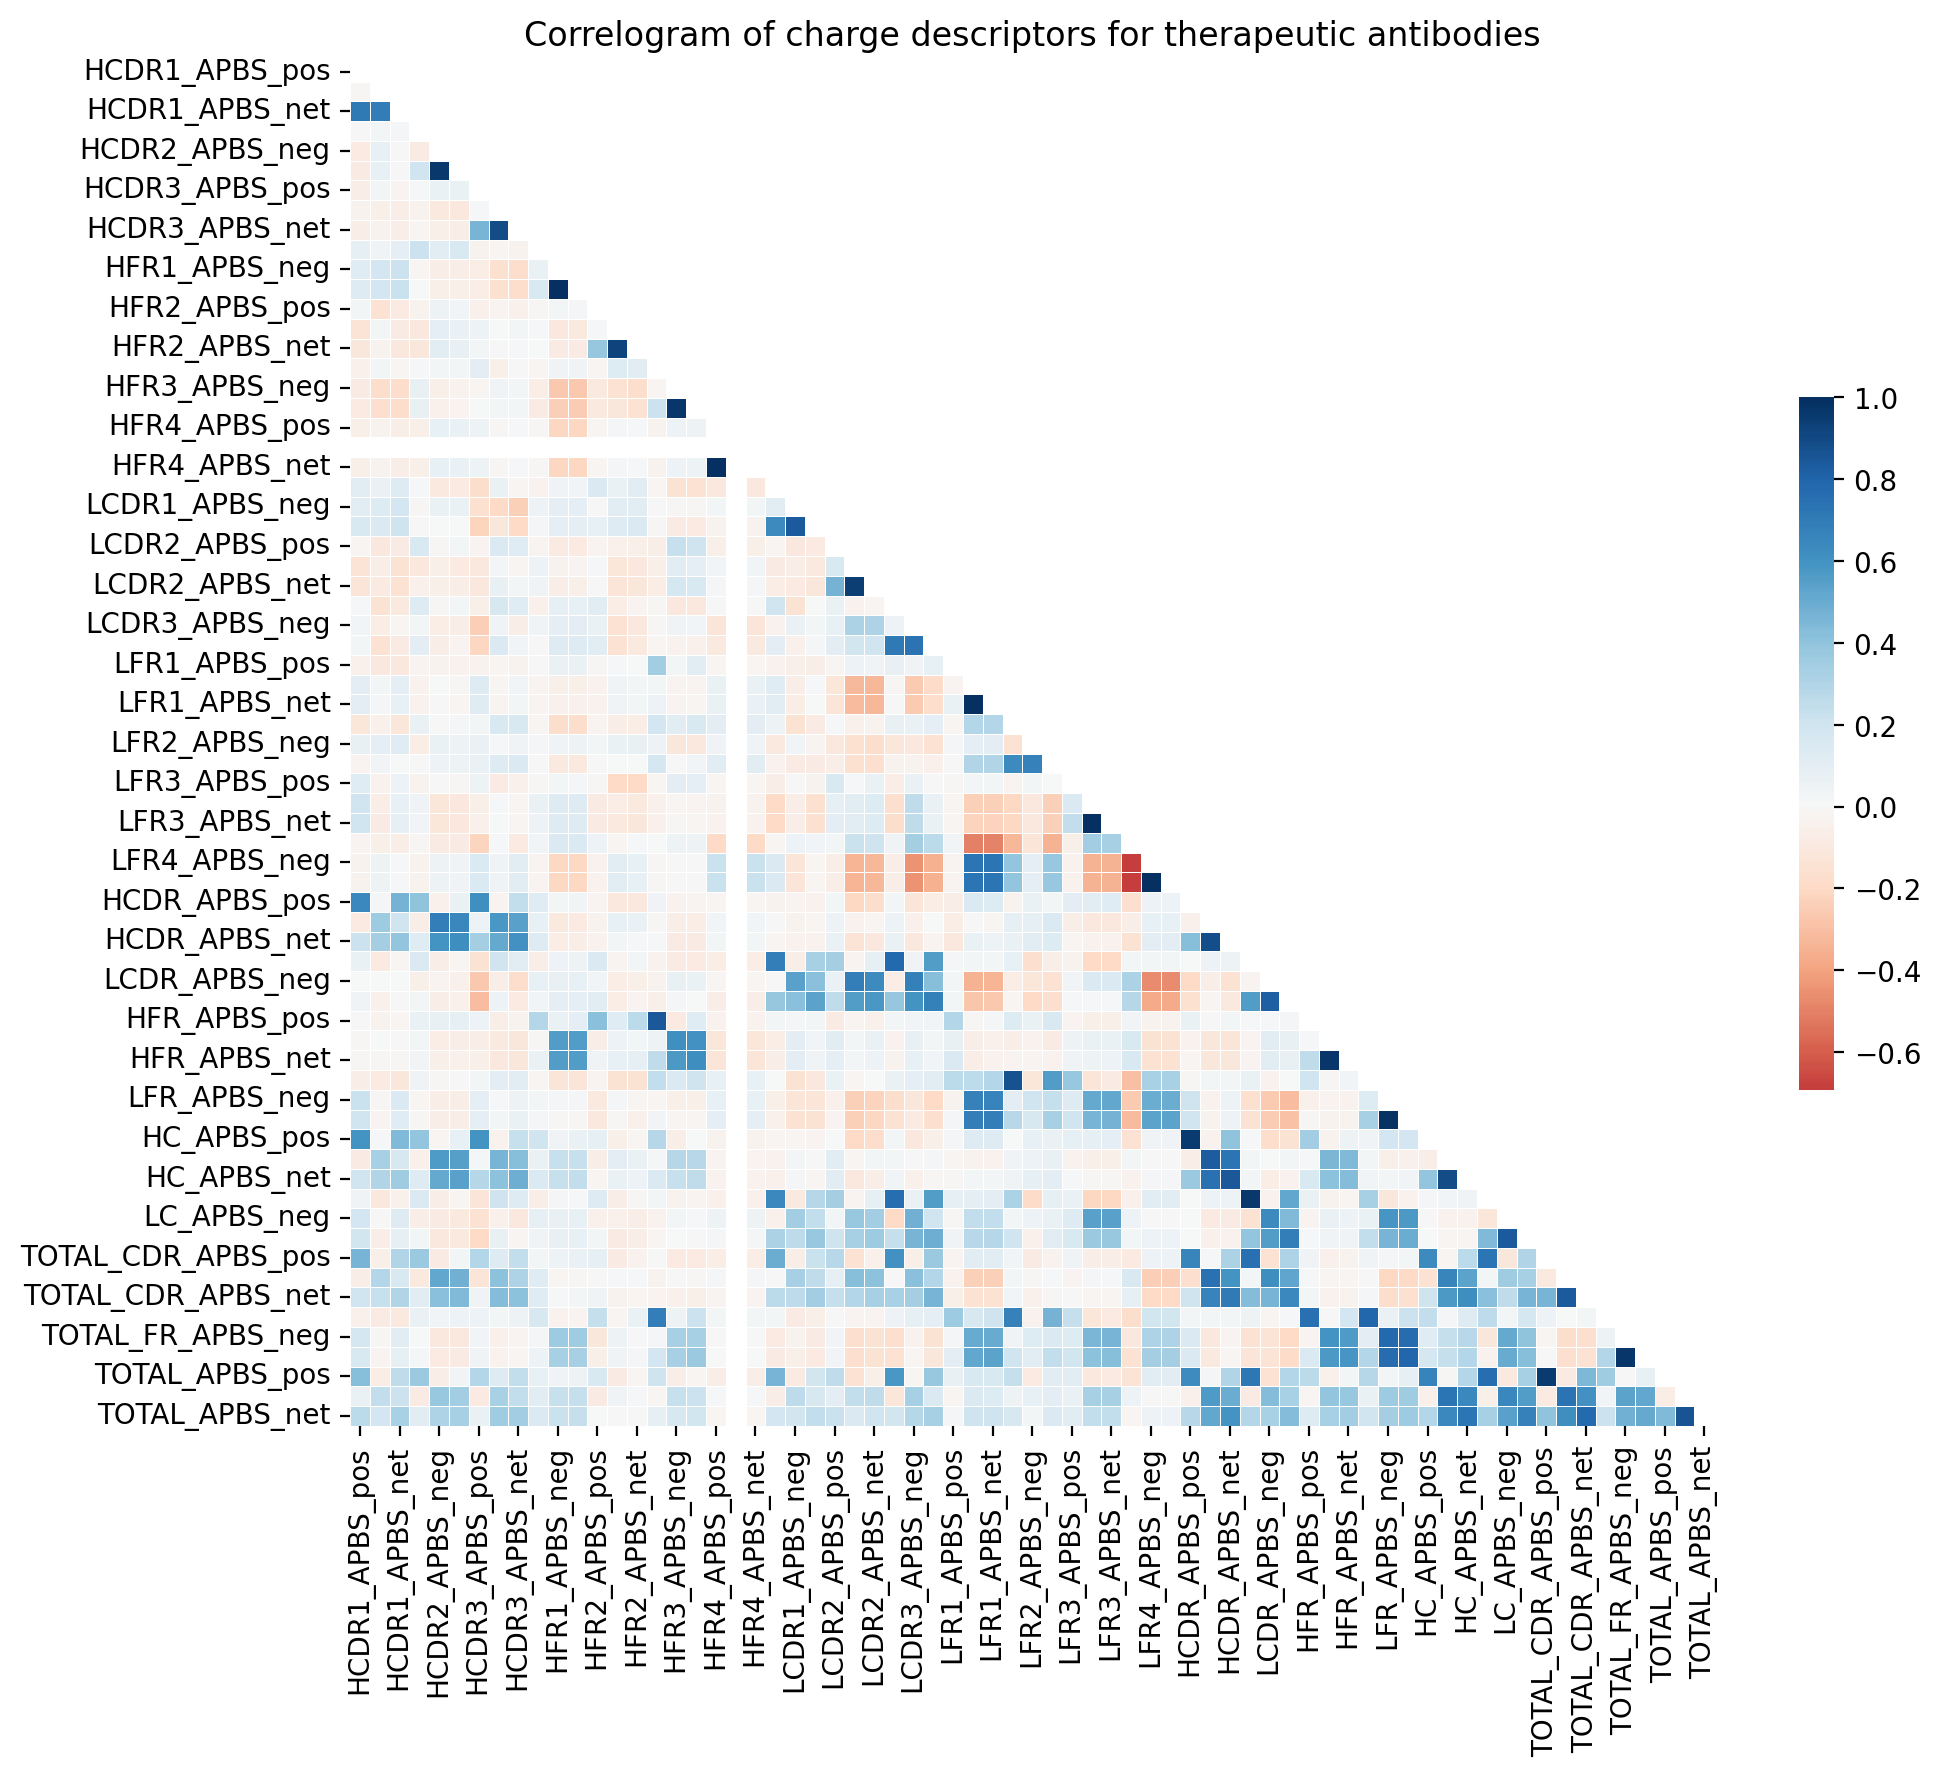

In [24]:
plot_correlogram(tab_region_charges, title = 'Correlogram of charge descriptors for therapeutic antibodies')

<Axes: title={'center': 'Correlogram of positive charges for Therapeutic antibodies'}>

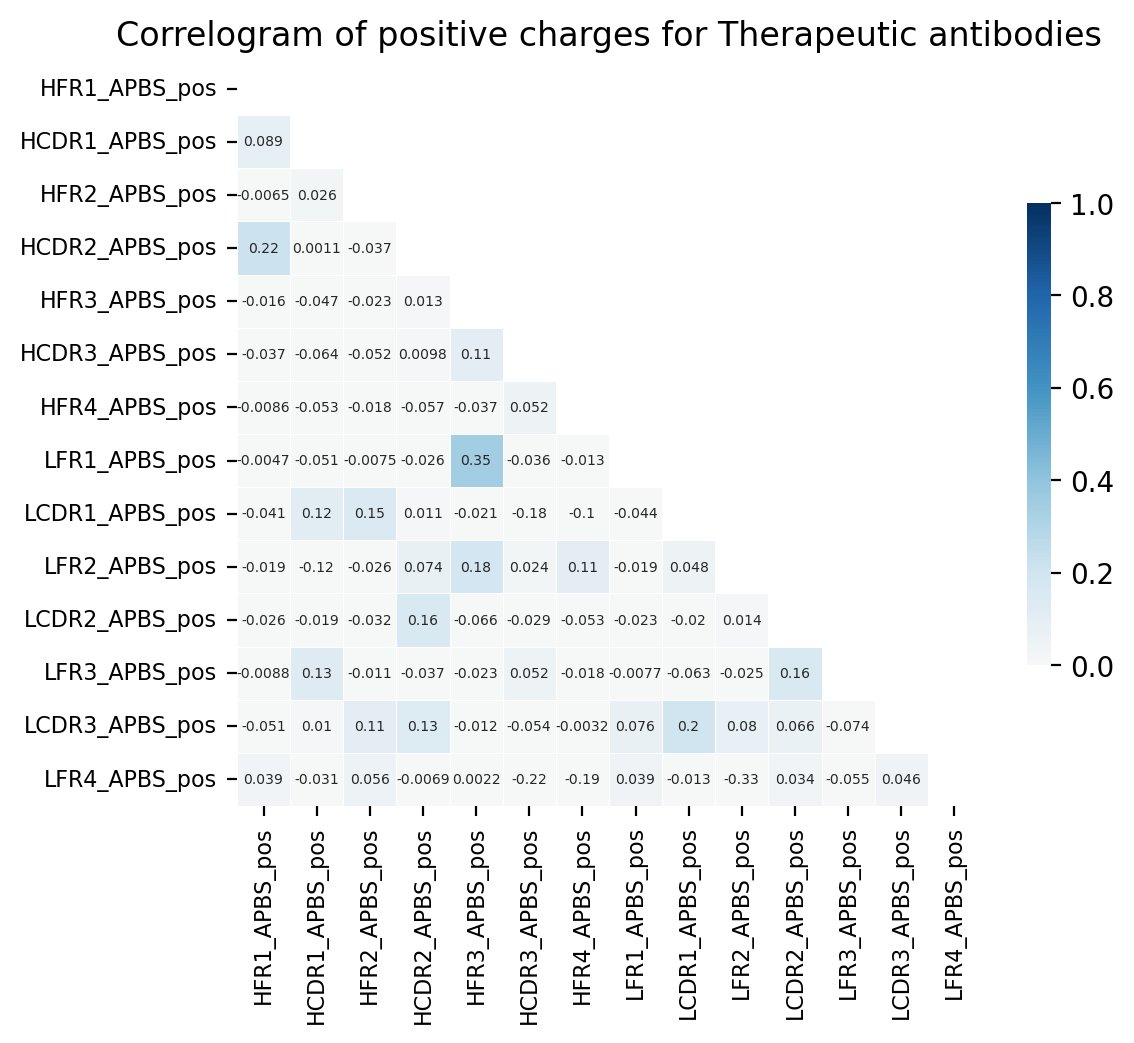

In [25]:

order = ['HFR1_APBS_pos', 'HCDR1_APBS_pos', 'HFR2_APBS_pos', 'HCDR2_APBS_pos', 'HFR3_APBS_pos', 'HCDR3_APBS_pos', 'HFR4_APBS_pos',
         'LFR1_APBS_pos', 'LCDR1_APBS_pos', 'LFR2_APBS_pos', 'LCDR2_APBS_pos', 'LFR3_APBS_pos', 'LCDR3_APBS_pos', 'LFR4_APBS_pos']

plot_correlogram(tab_region_charges[order], title = 'Correlogram of positive charges for Therapeutic antibodies', figsize = (6,6), annot = True, annot_kws = {'fontsize':5 }, vmin=0, vmax = 1,tick_label_size=8 )

<Axes: title={'center': 'Correlogram of charge descriptors for MPK190 Antibodies variants'}>

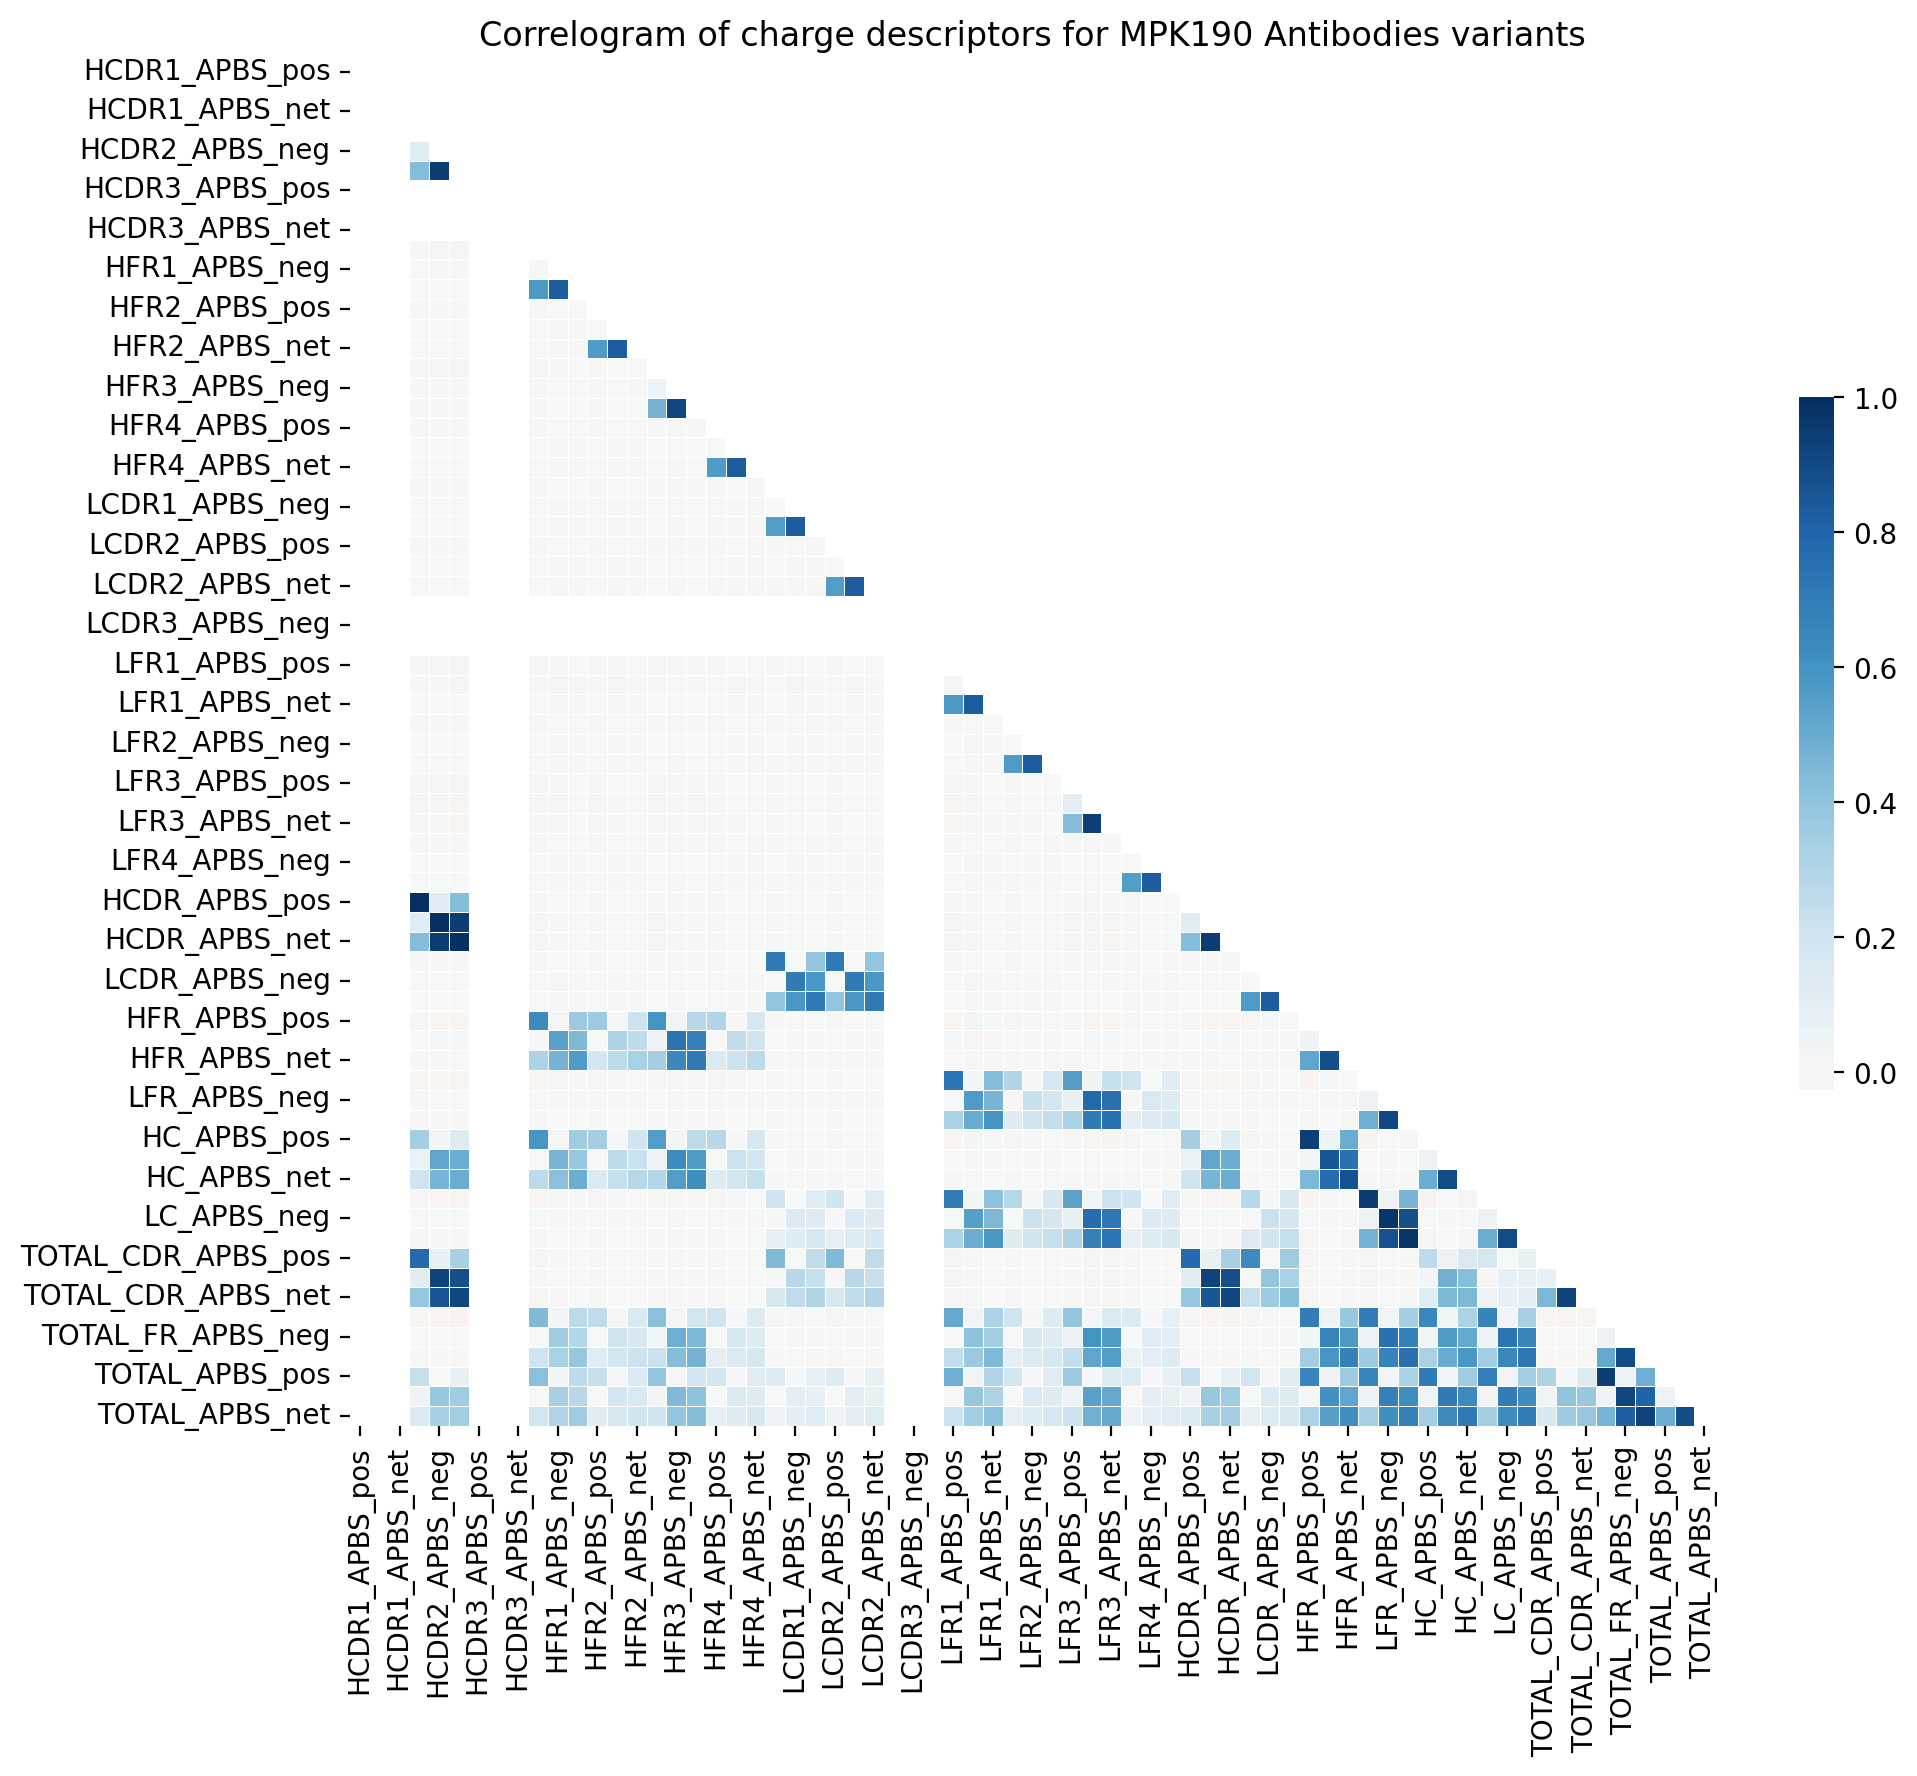

In [26]:
plot_correlogram(mpk190_region_charges, title = 'Correlogram of charge descriptors for MPK190 Antibodies variants')


<Axes: title={'center': 'Correlogram of charge descriptors for MPK190 Antibodies variants'}>

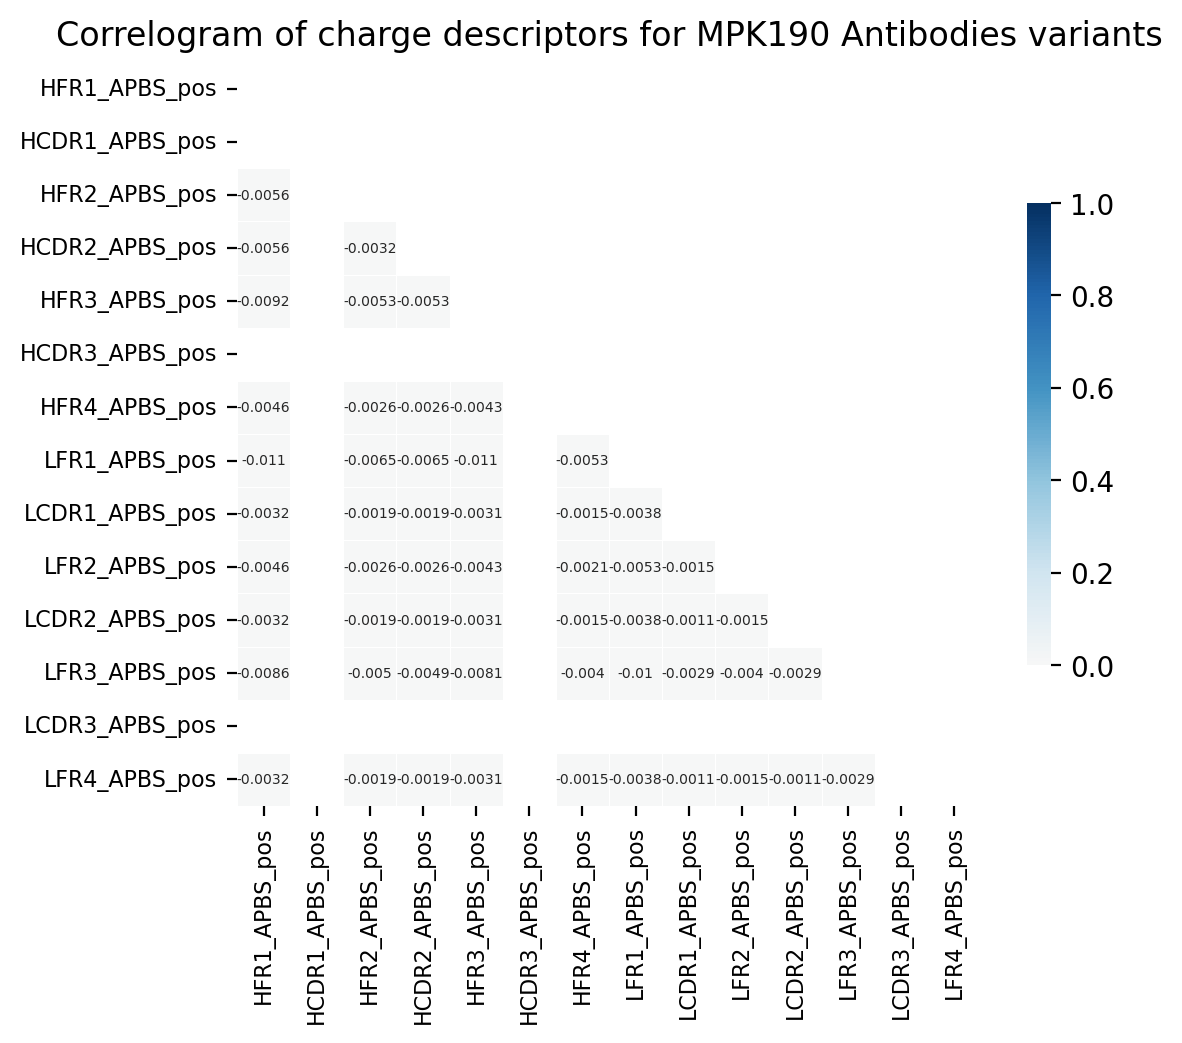

In [27]:
plot_correlogram(mpk190_region_charges[order], title = 'Correlogram of charge descriptors for MPK190 Antibodies variants', figsize = (6,6), 
                 annot = True, annot_kws = {'fontsize':5 }, vmin=0, vmax = 1,tick_label_size=8 )

#### Using Cross Correlation to measure potential similiarity along the sequence

In [28]:
from scipy.signal import correlate
import statsmodels.api as sm

In [29]:
tabs = list(tab_charges.keys())


def calcualate_acf(seq): 
    acf = sm.tsa.acf(seq, nlags=len(seq)-1)
    return acf

def calculate_ccf(seq1, seq2): 
    ccf = correlate(seq1, seq2, mode='full', method='fft')
    return ccf


def calculate_acf_for_fv_chains(df, name = 'ab'):
    lc_acf = calcualate_acf(df.query('FV_chain =="L"').total_pot.values)
    lc_acf = pd.DataFrame(dict(ACF=lc_acf, Lag = range(1, len(lc_acf)+1)))
    lc_acf['name'] = name
    
    hc_acf = calcualate_acf(df.query('FV_chain =="H"').total_pot.values)
    hc_acf = pd.DataFrame(dict(ACF=hc_acf, Lag = range(1, len(hc_acf)+1)))
    hc_acf['name'] = name

    return lc_acf, hc_acf

  0%|          | 0/931 [00:00<?, ?it/s]

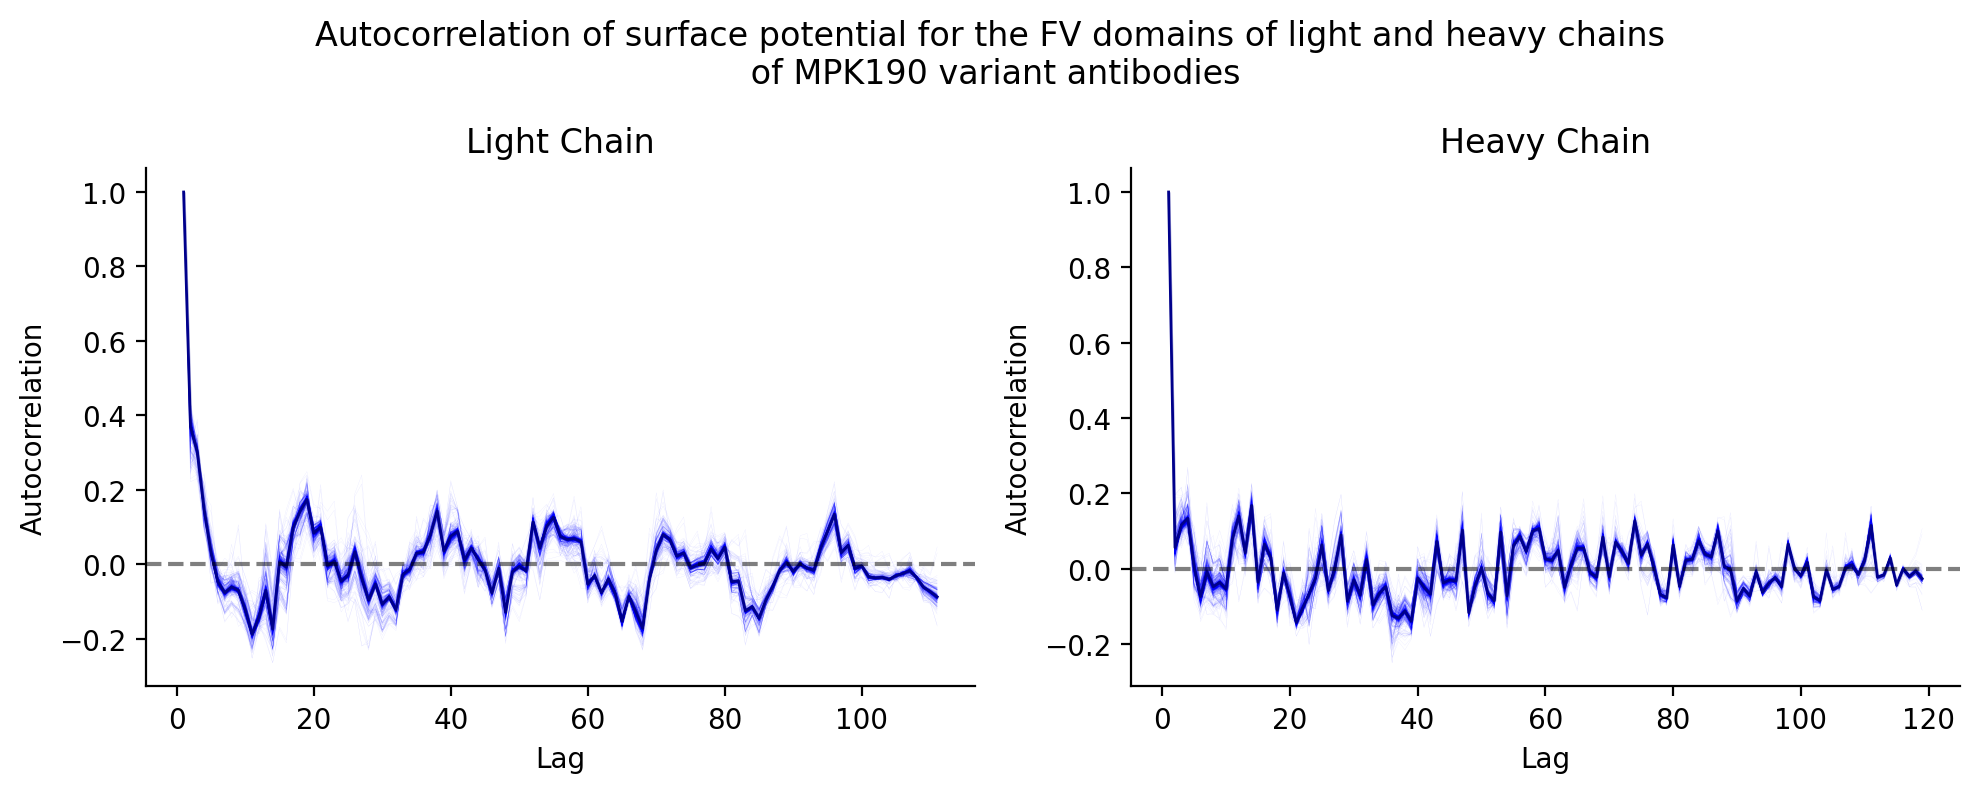

In [30]:
lc_acfs = []
hc_acfs = []

for name, df in tqdm(mpk_charges.items()):
    lc_acf, hc_acf = calculate_acf_for_fv_chains(df, name)
   
    lc_acfs.append(lc_acf)
    hc_acfs.append(hc_acf)

lc_acfs = pd.concat(lc_acfs, axis = 0)
hc_acfs = pd.concat(hc_acfs, axis = 0)


fig, axes = plt.subplots(1,2, figsize=(10,4))
color1 = 'blue'
color2 = 'darkblue'

ax = sns.lineplot(data=lc_acfs, x='Lag', y='ACF', units = 'name', estimator=None, alpha=0.1, ax = axes[0], color=color1, linewidth=0.1)
ax = sns.lineplot(data=lc_acfs, x='Lag', y='ACF', ax = axes[0], color = color2, linewidth=1)
ax.axhline(0, ls='--', color='black', alpha=0.5)
ax.set(title = 'Light Chain', xlabel='Lag', ylabel='Autocorrelation')


ax = sns.lineplot(data=hc_acfs, x='Lag', y='ACF', units = 'name', estimator=None, alpha=0.1, ax = axes[1],color=color1, linewidth=0.1)
ax = sns.lineplot(data=hc_acfs, x='Lag', y='ACF', ax = axes[1], color = color2, linewidth=1)
ax.axhline(0, ls='--', color='black', alpha=0.5)
ax.set(title = 'Heavy Chain', xlabel='Lag', ylabel='Autocorrelation')


fig.suptitle('Autocorrelation of surface potential for the FV domains of light and heavy chains\n of MPK190 variant antibodies')
sns.despine()
plt.tight_layout()

  0%|          | 0/177 [00:00<?, ?it/s]

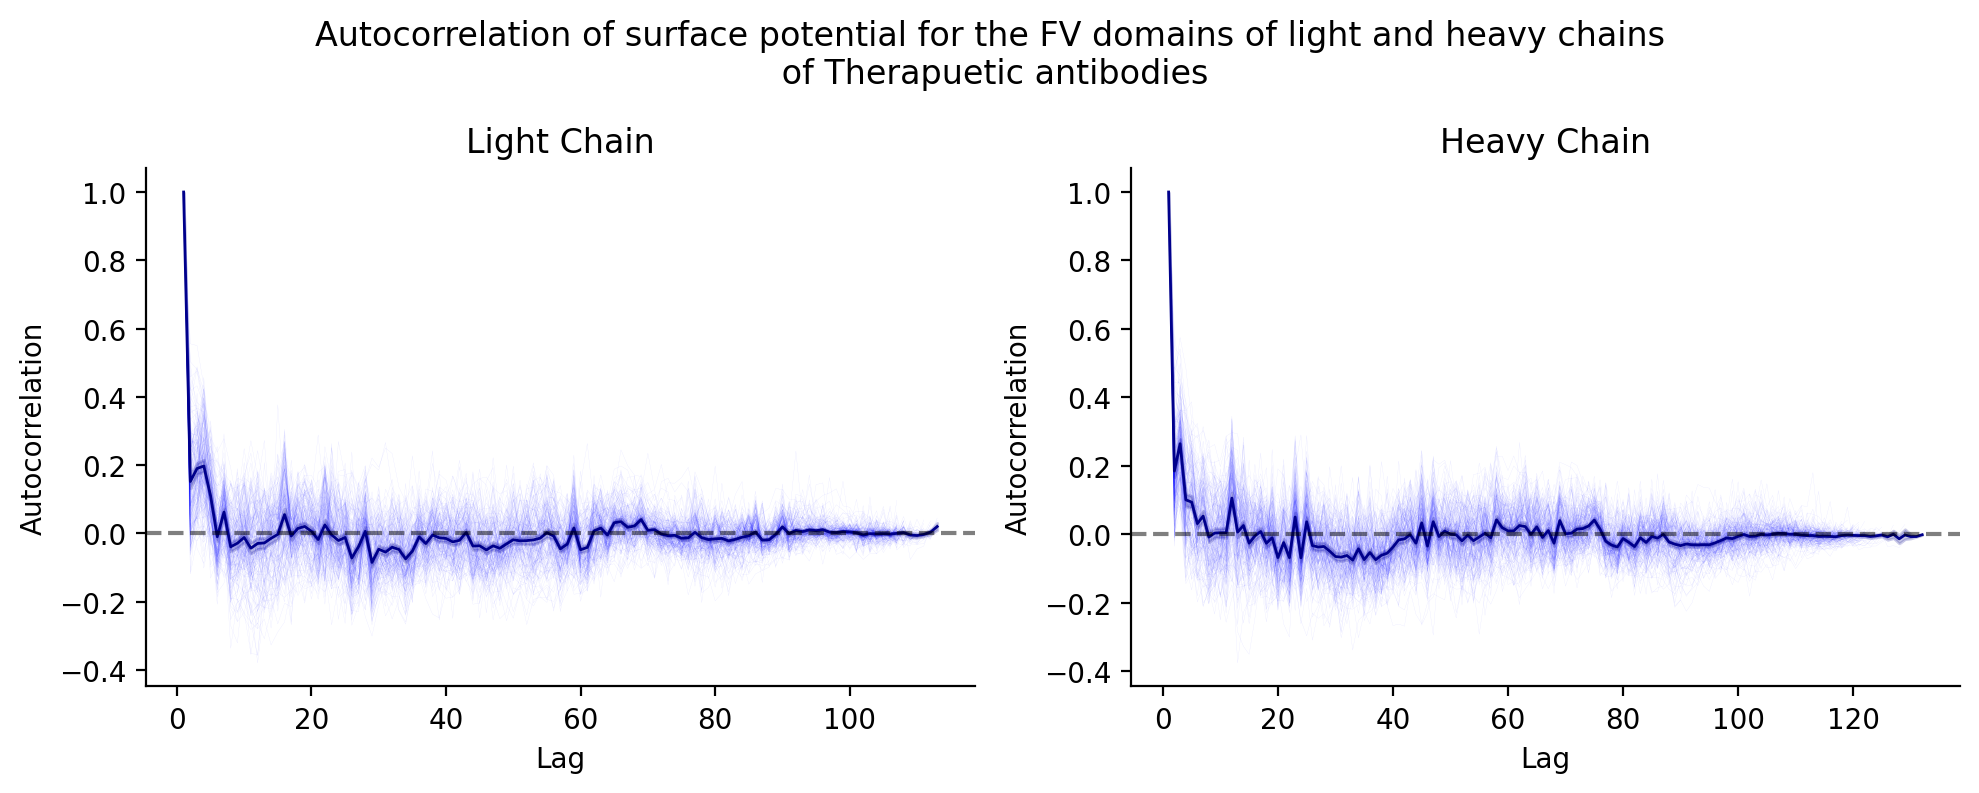

In [31]:
lc_acfs = []
hc_acfs = []

for name, df in tqdm(tab_charges.items()):
    lc_acf, hc_acf = calculate_acf_for_fv_chains(df, name)
   
    lc_acfs.append(lc_acf)
    hc_acfs.append(hc_acf)

lc_acfs = pd.concat(lc_acfs, axis = 0)
hc_acfs = pd.concat(hc_acfs, axis = 0)

fig, axes = plt.subplots(1,2, figsize=(10,4))
color1 = 'blue'
color2 = 'darkblue'

ax = sns.lineplot(data=lc_acfs, x='Lag', y='ACF', units = 'name', estimator=None, alpha=0.1, ax = axes[0], color=color1, linewidth=0.1)
ax = sns.lineplot(data=lc_acfs, x='Lag', y='ACF', ax = axes[0], color = color2, linewidth=1)
ax.axhline(0, ls='--', color='black', alpha=0.5)
ax.set(title = 'Light Chain', xlabel='Lag', ylabel='Autocorrelation')


ax = sns.lineplot(data=hc_acfs, x='Lag', y='ACF', units = 'name', estimator=None, alpha=0.1, ax = axes[1],color=color1, linewidth=0.1)
ax = sns.lineplot(data=hc_acfs, x='Lag', y='ACF', ax = axes[1], color = color2, linewidth=1)
ax.axhline(0, ls='--', color='black', alpha=0.5)
ax.set(title = 'Heavy Chain', xlabel='Lag', ylabel='Autocorrelation')


fig.suptitle('Autocorrelation of surface potential for the FV domains of light and heavy chains\n of Therapuetic antibodies')
sns.despine()
plt.tight_layout()

### load the descriptors file for the therapeutic antibodies and MPK190 variants

In [32]:
tab_descriptors = therapeutic_ab_path/'solved_structure_descriptors.pq'

if not tab_descriptors.exists():

    tab_descriptors = pd.concat([calculate_descriptors(df, name) for name, df in tab_charges.items()])
    tab_descriptors.to_parquet(therapeutic_ab_path/'solved_structure_descriptors.pq')
else: 
    tab_descriptors = pd.read_parquet(tab_descriptors)

<Axes: title={'center': 'Correlogram of positive descriptors for Therapeutic antibodies'}>

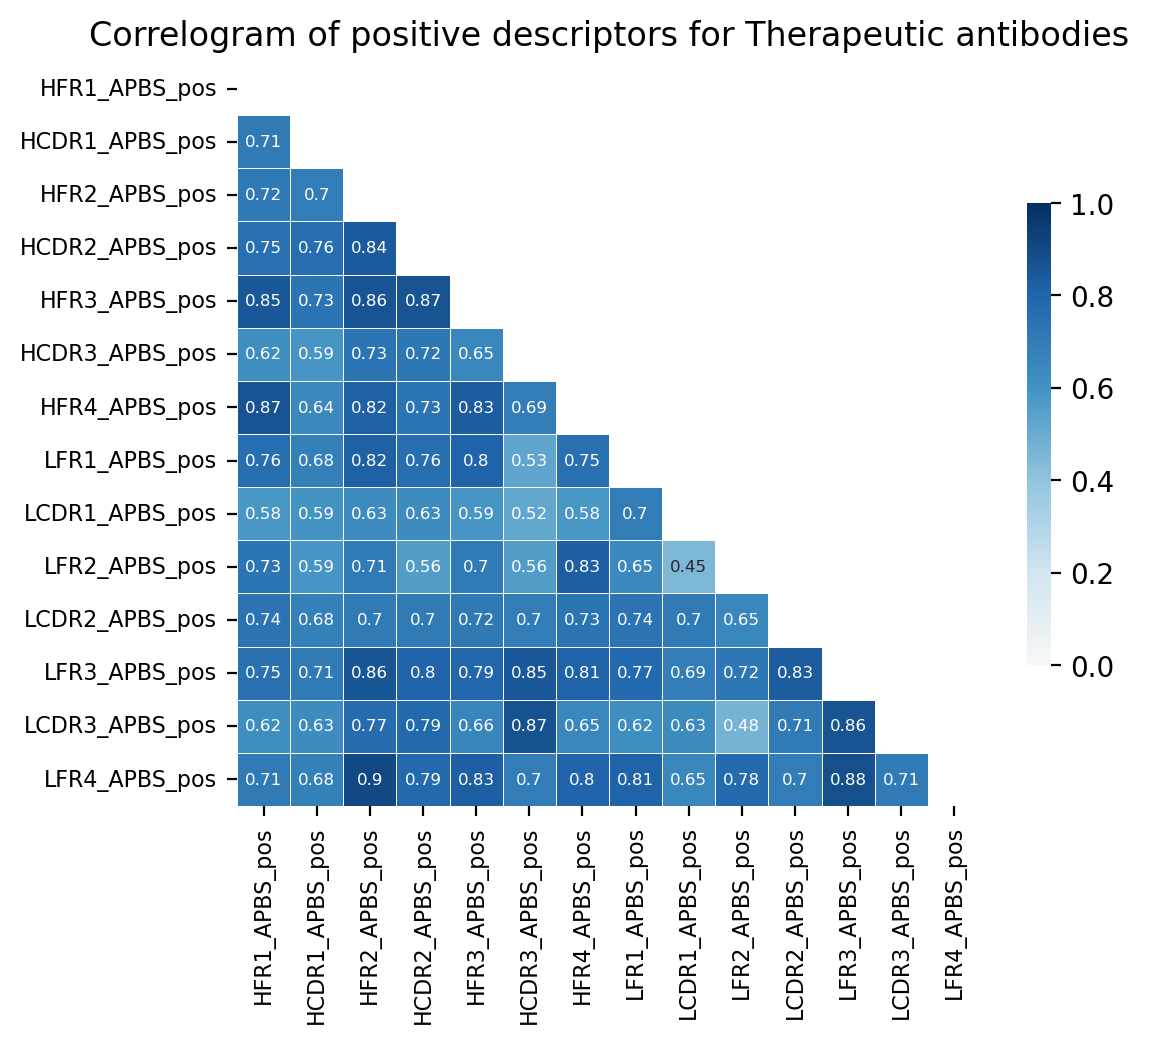

In [33]:

order = ['HFR1_APBS_pos', 'HCDR1_APBS_pos', 'HFR2_APBS_pos', 'HCDR2_APBS_pos', 'HFR3_APBS_pos', 'HCDR3_APBS_pos', 'HFR4_APBS_pos',
         'LFR1_APBS_pos', 'LCDR1_APBS_pos', 'LFR2_APBS_pos', 'LCDR2_APBS_pos', 'LFR3_APBS_pos', 'LCDR3_APBS_pos', 'LFR4_APBS_pos']

pos_descriptors = tab_descriptors[order].copy()

plot_correlogram(pos_descriptors, title = 'Correlogram of positive descriptors for Therapeutic antibodies', figsize = (6,6), annot = True, annot_kws = {'fontsize':6 }, vmin=0, vmax = 1,tick_label_size=8 )


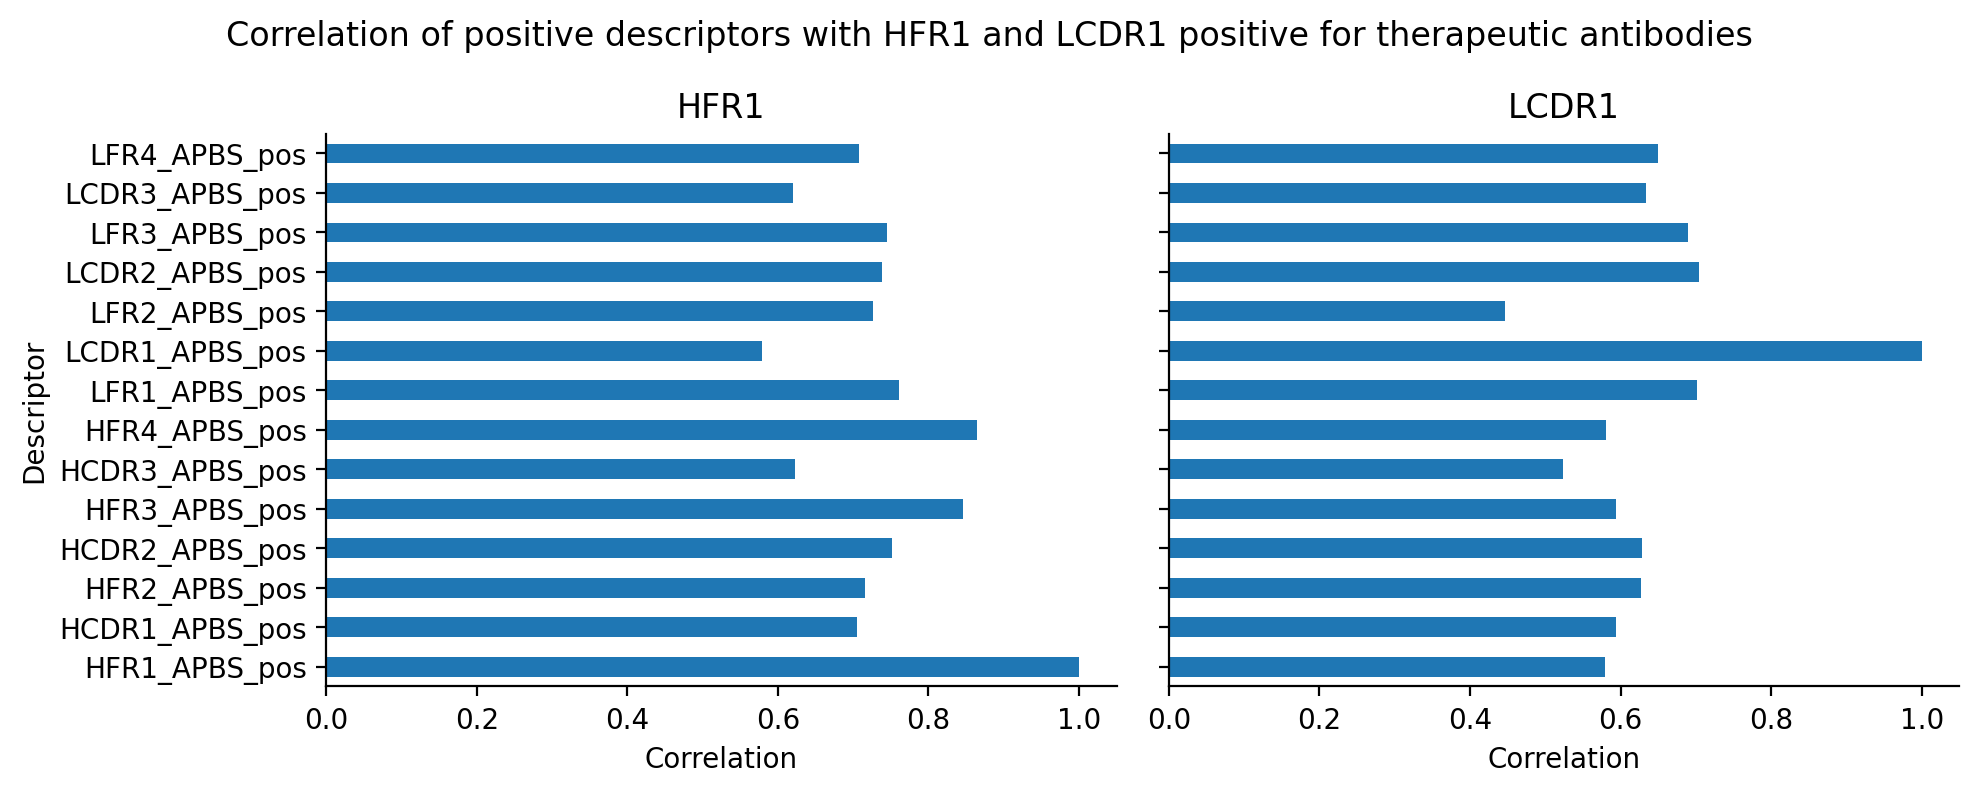

In [34]:
HFR1_corr = pos_descriptors.corrwith(pos_descriptors['HFR1_APBS_pos'])
LCDR1_corr = pos_descriptors.corrwith(pos_descriptors['LCDR1_APBS_pos'])

fig, axes = plt.subplots(1,2, figsize=(10,4))
ax=HFR1_corr.plot(kind = 'barh', ax= axes[0])
ax.set(title = 'HFR1', xlabel='Correlation', ylabel='Descriptor')

ax=LCDR1_corr.plot(kind = 'barh', ax= axes[1])
ax.set(title = 'LCDR1', xlabel='Correlation', yticklabels="")

fig.suptitle('Correlation of positive descriptors with HFR1 and LCDR1 positive for therapeutic antibodies')
sns.despine()
plt.tight_layout()


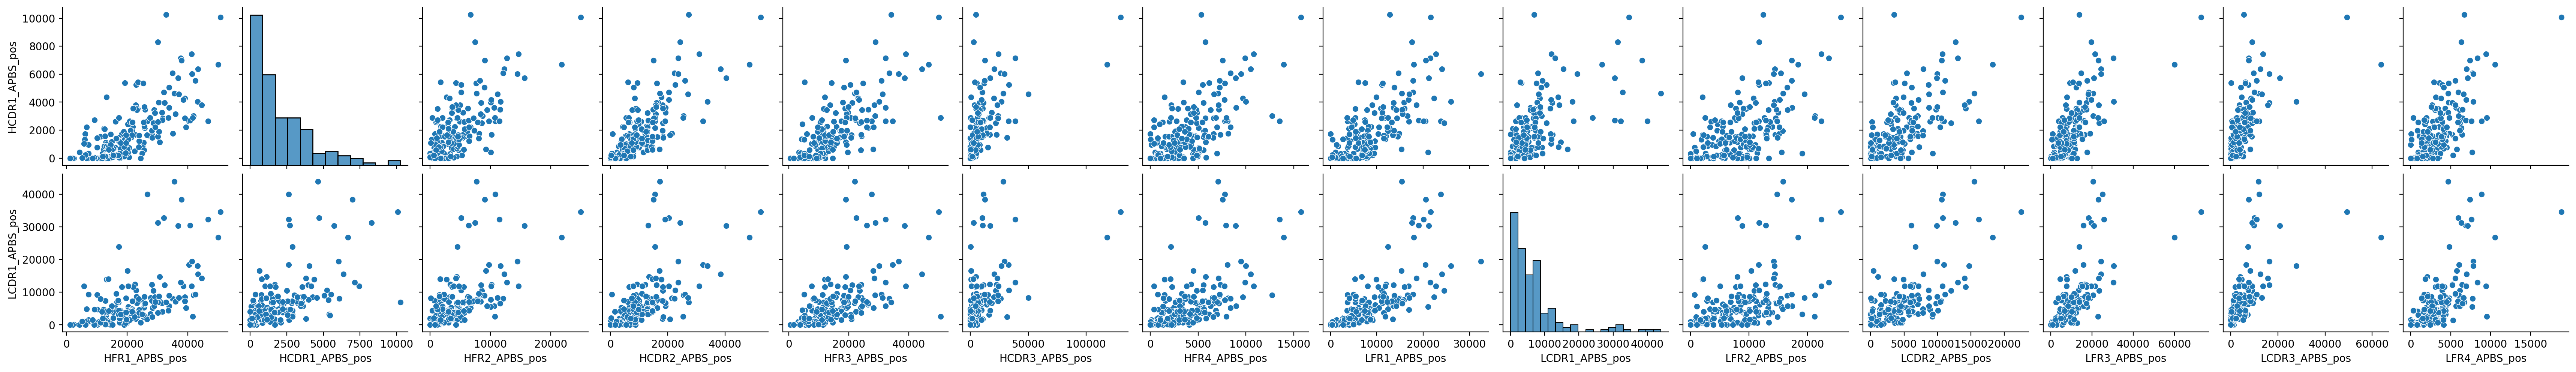

In [35]:
sns.pairplot(data = pos_descriptors, y_vars = ['HCDR1_APBS_pos', 'LCDR1_APBS_pos'])

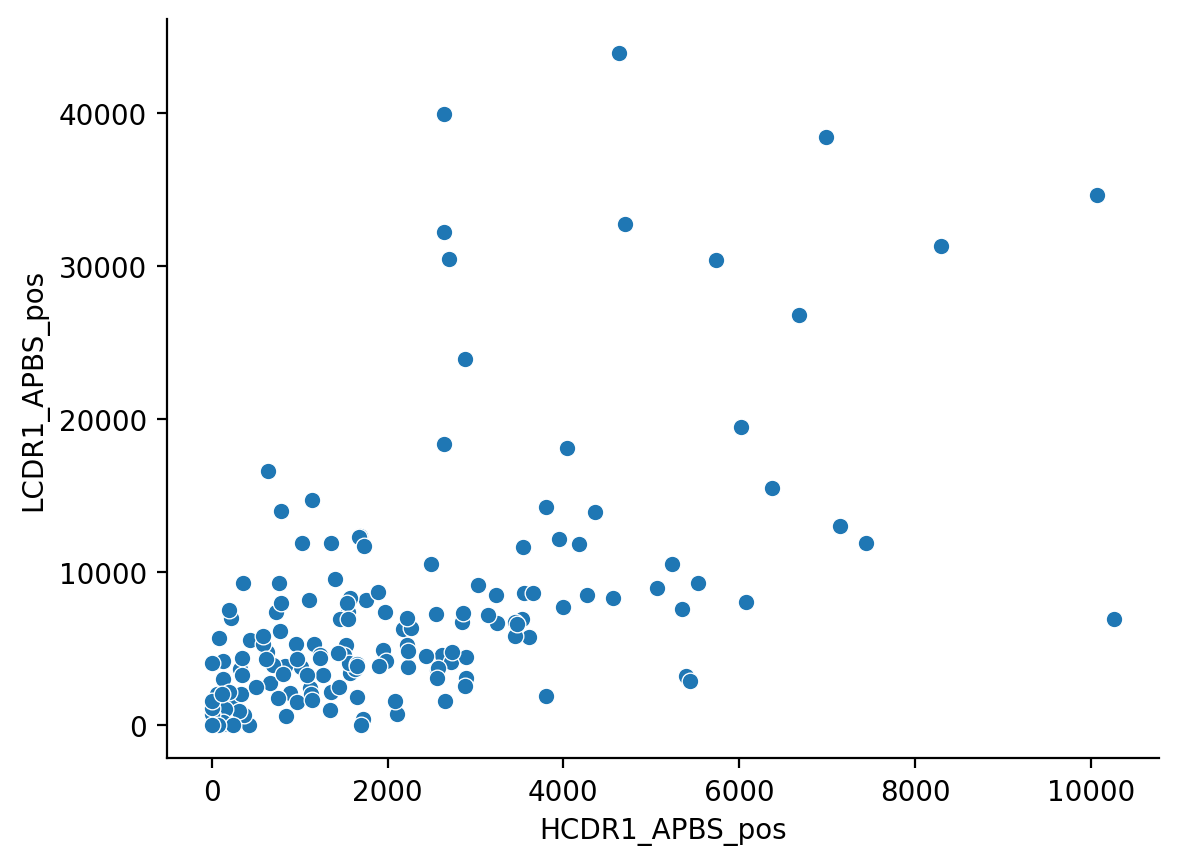

In [36]:
sns.scatterplot(data = pos_descriptors, x = 'HCDR1_APBS_pos', y= 'LCDR1_APBS_pos')
sns.despine()

#### Now the mpk1 

<Axes: title={'center': 'Correlogram of positive descriptors for MPK190 variants'}>

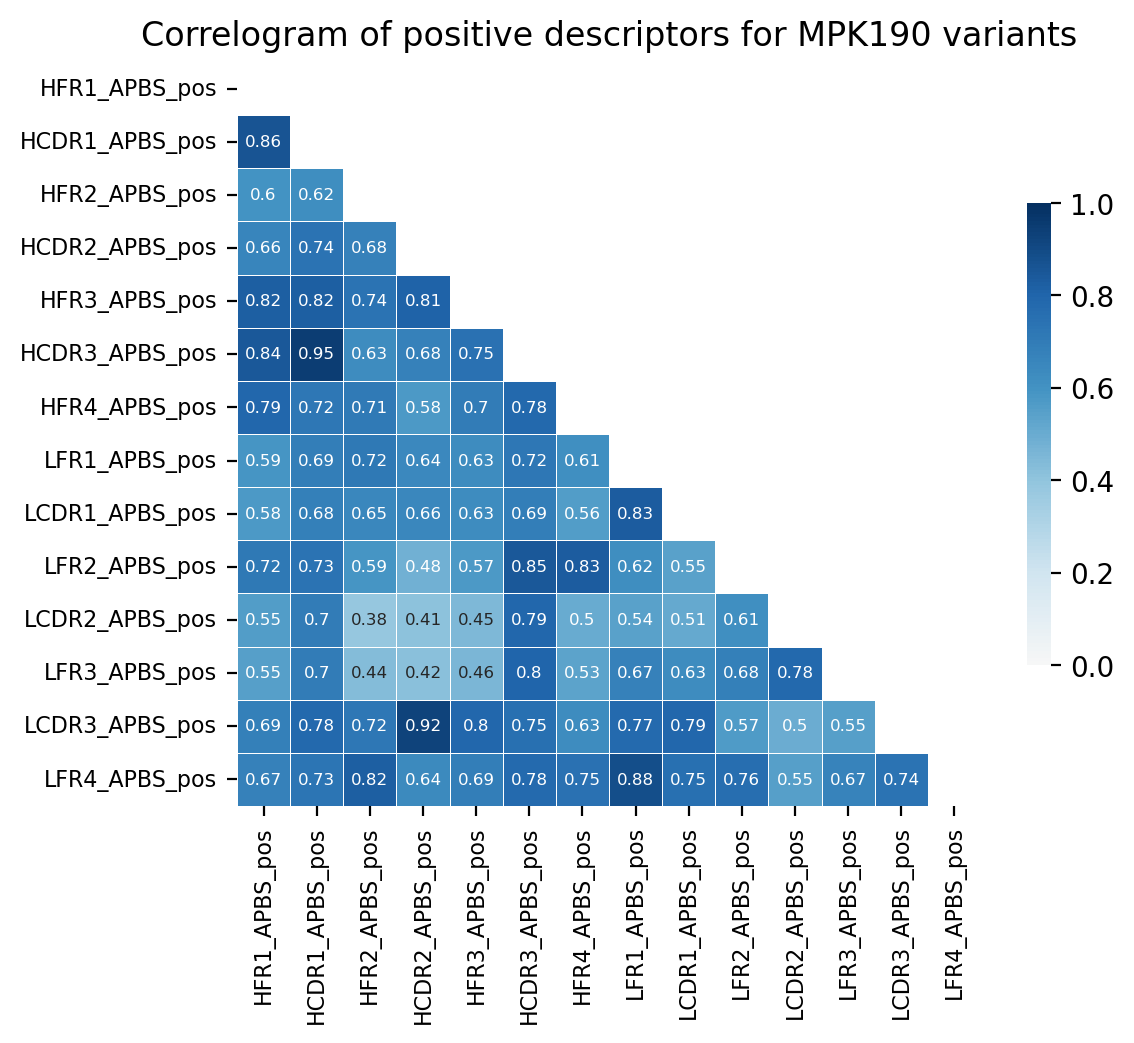

In [37]:
mpk190_descriptors = pd.read_parquet(mpk190_v10_path/'descriptors.parquet')
pos_mpk190 = mpk190_descriptors[order].copy()

plot_correlogram(pos_mpk190, title = 'Correlogram of positive descriptors for MPK190 variants', figsize = (6,6), annot = True, annot_kws = {'fontsize':6 }, vmin=0, vmax = 1,tick_label_size=8 )


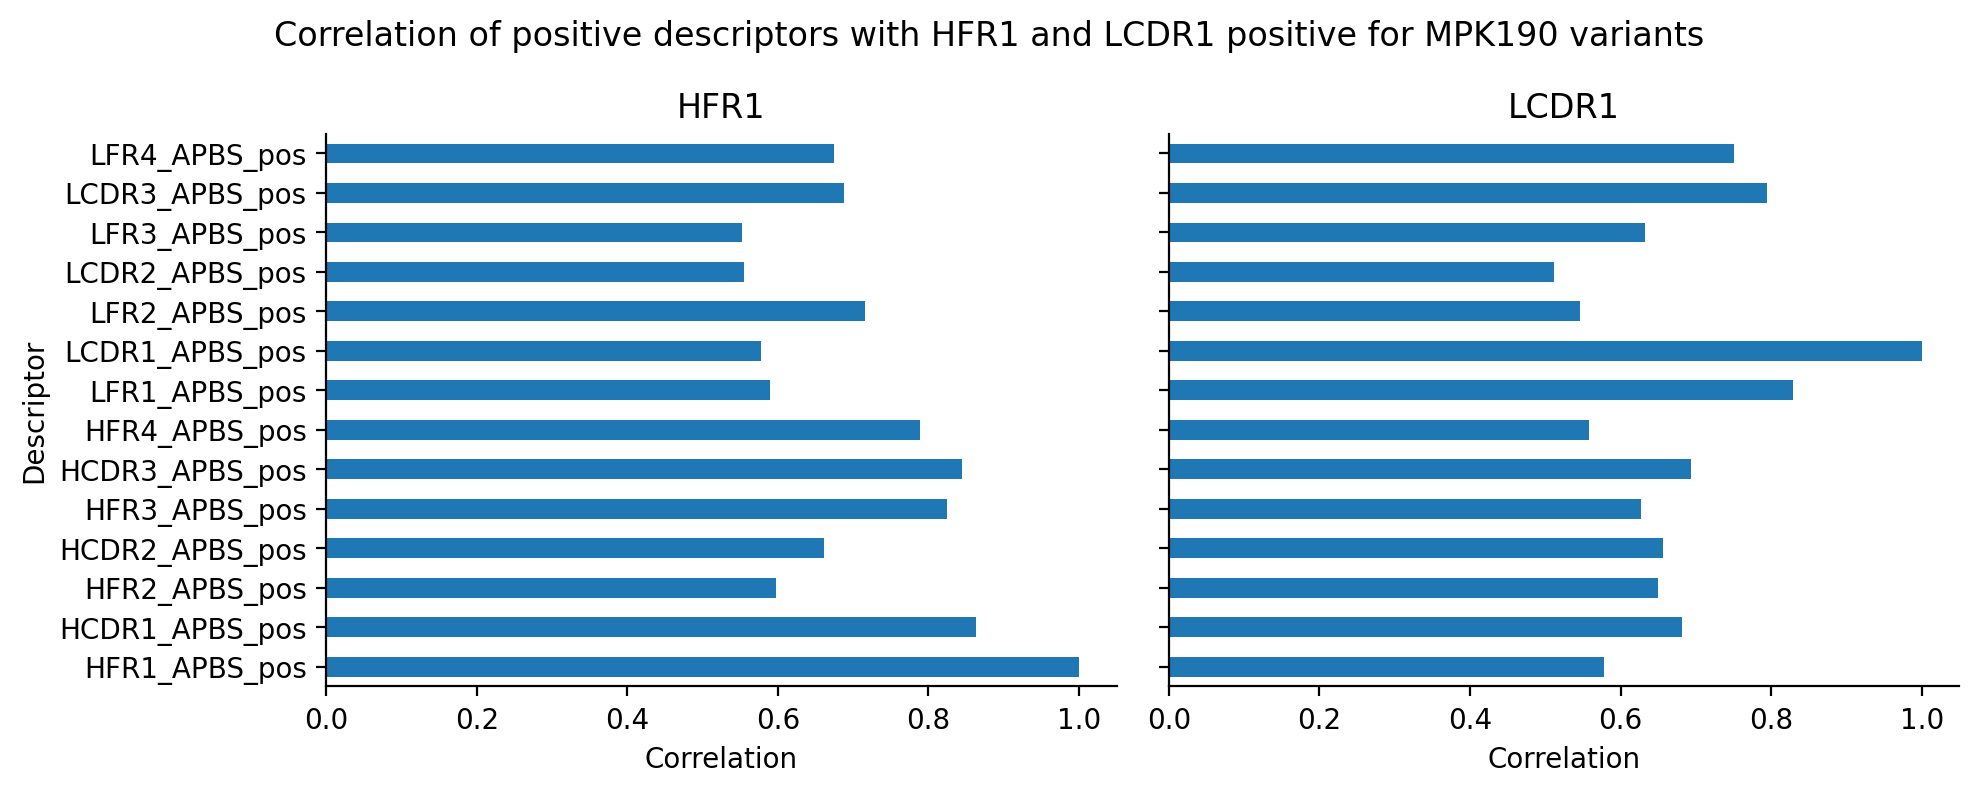

In [38]:
HFR1_corr = pos_mpk190.corrwith(pos_mpk190['HFR1_APBS_pos'])
LCDR1_corr = pos_mpk190.corrwith(pos_mpk190['LCDR1_APBS_pos'])

fig, axes = plt.subplots(1,2, figsize=(10,4))
ax=HFR1_corr.plot(kind = 'barh', ax= axes[0])
ax.set(title = 'HFR1', xlabel='Correlation', ylabel='Descriptor')

ax=LCDR1_corr.plot(kind = 'barh', ax= axes[1])
ax.set(title = 'LCDR1', xlabel='Correlation', yticklabels="")

fig.suptitle('Correlation of positive descriptors with HFR1 and LCDR1 positive for MPK190 variants')
sns.despine()
plt.tight_layout()


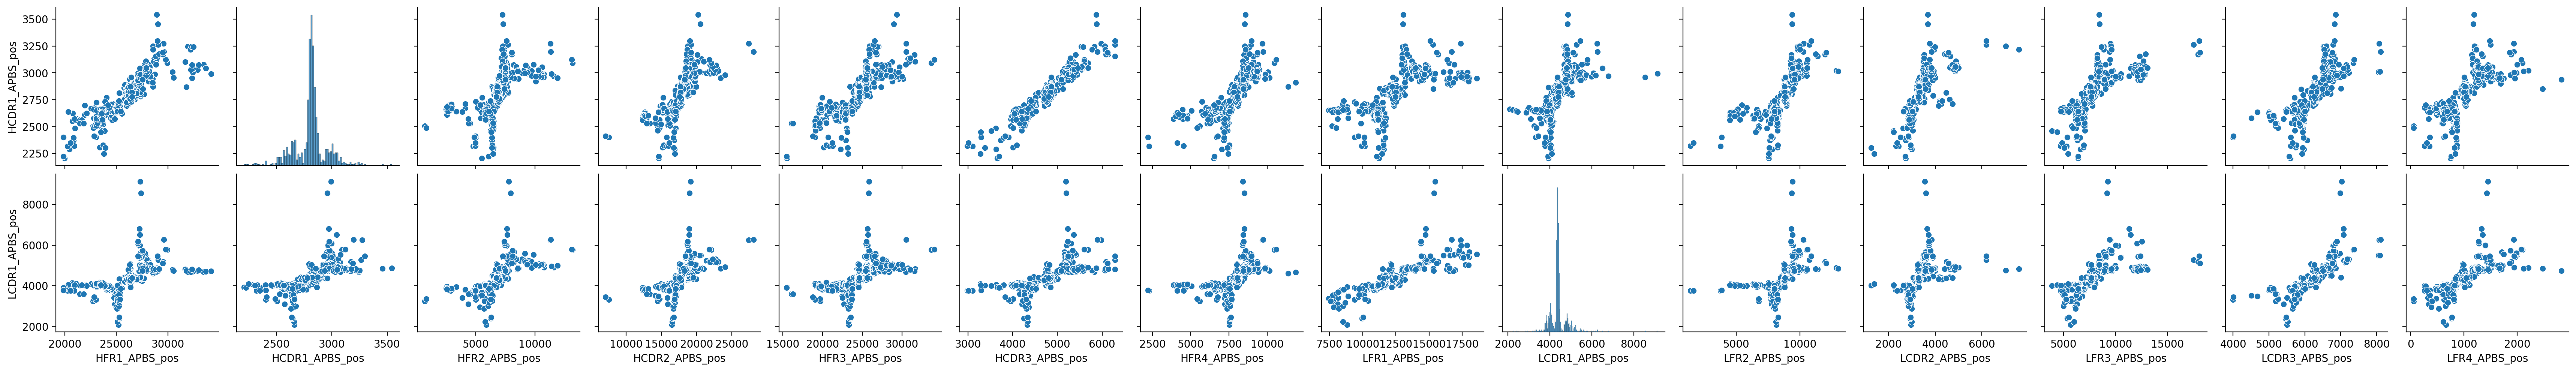

In [39]:
sns.pairplot(data = pos_mpk190, y_vars = ['HCDR1_APBS_pos', 'LCDR1_APBS_pos'])

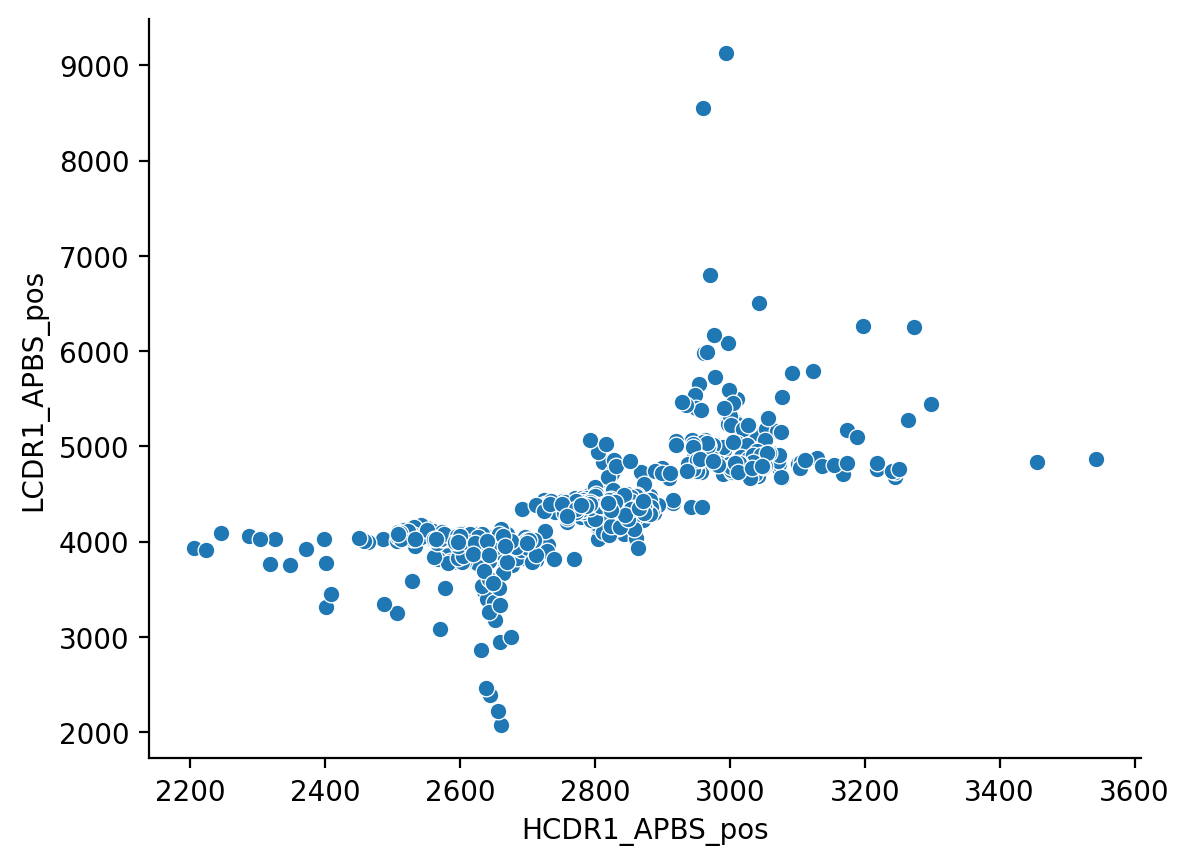

In [40]:
sns.scatterplot(data = pos_mpk190, x = 'HCDR1_APBS_pos', y= 'LCDR1_APBS_pos')
sns.despine()

In [41]:
charge_corr = mpk190_region_charges.corr()
charge_corr.head()

HCDR1_APBS_pos  HCDR1_APBS_neg  HCDR1_APBS_net  \
HCDR1_APBS_pos             NaN             NaN             NaN   
HCDR1_APBS_neg             NaN             NaN             NaN   
HCDR1_APBS_net             NaN             NaN             NaN   
HCDR2_APBS_pos             NaN             NaN             NaN   
HCDR2_APBS_neg             NaN             NaN             NaN   

                HCDR2_APBS_pos  HCDR2_APBS_neg  HCDR2_APBS_net  \
HCDR1_APBS_pos             NaN             NaN             NaN   
HCDR1_APBS_neg             NaN             NaN             NaN   
HCDR1_APBS_net             NaN             NaN             NaN   
HCDR2_APBS_pos        1.000000        0.118631        0.430524   
HCDR2_APBS_neg        0.118631        1.000000        0.947279   

                HCDR3_APBS_pos  HCDR3_APBS_neg  HCDR3_APBS_net  HFR1_APBS_pos  \
HCDR1_APBS_pos             NaN             NaN             NaN            NaN   
HCDR1_APBS_neg             NaN             NaN             NaN            NaN   
HCDR1_APBS_net             NaN             NaN             NaN            NaN   
HCDR2_APBS_pos             NaN             NaN             NaN      -0.005599   
HCDR2_APBS_neg             NaN             NaN             NaN      -0.009719   

                HFR1_APBS_neg  HFR1_APBS_net  HFR2_APBS_pos  HFR2_APBS_neg  \
HCDR1_APBS_pos            NaN            NaN            NaN            NaN   
HCDR1_APBS_neg            NaN            NaN            NaN            NaN   
HCDR1_APBS_net            NaN            NaN            NaN            NaN   
HCDR2_APBS_pos       0.007951       0.003398      -0.003222       0.004561   
HCDR2_APBS_neg       0.013802       0.005898      -0.005593       0.007917   

                HFR2_APBS_net  HFR3_APBS_pos  HFR3_APBS_neg  HFR3_APBS_net  \
HCDR1_APBS_pos            NaN            NaN            NaN            NaN   
HCDR1_APBS_neg            NaN            NaN            NaN            NaN   
HCDR1_APBS_net            NaN            NaN            NaN            NaN   
HCDR2_APBS_pos       0.001959      -0.005266      -0.001312      -0.003374   
HCDR2_APBS_neg       0.003401      -0.009142      -0.002278      -0.005857   

                HFR4_APBS_pos  HFR4_APBS_neg  HFR4_APBS_net  LCDR1_APBS_pos  \
HCDR1_APBS_pos            NaN            NaN            NaN             NaN   
HCDR1_APBS_neg            NaN            NaN            NaN             NaN   
HCDR1_APBS_net            NaN            NaN            NaN             NaN   
HCDR2_APBS_pos      -0.002629       0.003720       0.001600       -0.001858   
HCDR2_APBS_neg      -0.004564       0.006457       0.002777       -0.003226   

                LCDR1_APBS_neg  LCDR1_APBS_net  LCDR2_APBS_pos  \
HCDR1_APBS_pos             NaN             NaN             NaN   
HCDR1_APBS_neg             NaN             NaN             NaN   
HCDR1_APBS_net             NaN             NaN             NaN   
HCDR2_APBS_pos        0.002627        0.001131       -0.001858   
HCDR2_APBS_neg        0.004561        0.001963       -0.003226   

                LCDR2_APBS_neg  LCDR2_APBS_net  LCDR3_APBS_pos  \
HCDR1_APBS_pos             NaN             NaN             NaN   
HCDR1_APBS_neg             NaN             NaN             NaN   
HCDR1_APBS_net             NaN             NaN             NaN   
HCDR2_APBS_pos        0.002627        0.001131             NaN   
HCDR2_APBS_neg        0.004561        0.001963             NaN   

                LCDR3_APBS_neg  LCDR3_APBS_net  LFR1_APBS_pos  LFR1_APBS_neg  \
HCDR1_APBS_pos             NaN             NaN            NaN            NaN   
HCDR1_APBS_neg             NaN             NaN            NaN            NaN   
HCDR1_APBS_net             NaN             NaN            NaN            NaN   
HCDR2_APBS_pos             NaN             NaN      -0.006476       0.009212   
HCDR2_APBS_neg             NaN             NaN      -0.011241       0.015990   

                LFR1_APBS_net  LFR2_APBS_pos  L

In [42]:
charge_corr.loc['LFR4_APBS_pos', 'HFR1_APBS_pos']

-0.0032447495722735436

### Try looking at partition of charge by chunks of 10 residues. 

In [43]:
def partition_potentials(residue_pot_df, max_partitions=10): 
    """ Calculates the potentials for partions of the FV domain (which are arbitrary)
    Args: 
        residue_pot_df(pd.DataFrame): annotated DataFrame with the residue potentials 
    Returns: 
        vals(dict): dict with values

    """
    
    def calculate_total_potential(partition, chain, charge='pos'): 
        """ Calculates the potential for a region
        Args: 
            region(str|list[str]): the region to calculate
            chain(str|list[str]): the chain to calculate
            charge(str): the charge to calculate
        Returns: 
            float: the potential for the region
        """

        if isinstance(partition, str):  
            chain = [partition]

        if charge=='pos':
            df = residue_pot_df.query('total_pot > 0')
        elif charge=='neg':
            df = residue_pot_df.query('total_pot < 0')
        elif charge=='net':
            df = residue_pot_df
        else:
            raise ValueError('charge must be pos, neg or net')  

        return df.query('partition ==@partition and FV_chain==@chain')['total_pot'].sum()
            
    partitions = range(1, max_partitions+1)
    
    charges = ['pos', 'neg', 'net']
    chains = ['L', 'H']

    vals = {f'{chain}{partition}_APBS_{charge}': calculate_total_potential(partition, chain, charge) for 
            chain in chains for partition in partitions for charge in charges}
    
    
    return vals

def calculate_descriptors_on_partitions(df,name,partition_size=10, on_charge=False):
    if on_charge: 
        df = df.copy().drop('total_pot', axis=1).rename({'Charge': 'total_pot'}, axis = 1)
    
    df = (df.query('FV_chain!="NonFV"')
          .copy()
          .reset_index(drop=True)
          )
    
    counts= df['FV_chain'].value_counts()
    c1, c2 = counts.values
    df['chain_number'] = list(range(1, c1+1)) + list(range(1, c2+1))
    df['partition'] = df['chain_number']//partition_size +1
    
    
    return calculate_descriptors(df, name, features = [partition_potentials])

In [44]:
tab_partitions = pd.concat([calculate_descriptors_on_partitions(df,name) for name, df in tqdm(tab_charges.items())])
mpk190_partitions = pd.concat([calculate_descriptors_on_partitions(df,name) for name, df in tqdm(mpk_charges.items())])

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/931 [00:00<?, ?it/s]

In [45]:
tab_partitions.head()

L1_APBS_pos  L1_APBS_neg  L1_APBS_net  L2_APBS_pos  \
gevokizumab    4309.228897     0.000000  4309.228897  3173.077130   
navivumab      5481.376649     0.000000  5481.376649  5026.386915   
guselkumab     9640.423806     0.000000  9640.423806  6345.748719   
lebrikizumab   3682.002806  -881.527308  2800.475497  2302.676431   
duligotuzumab   789.285825 -1933.057116 -1143.771291  1742.437947   

               L2_APBS_neg  L2_APBS_net  L3_APBS_pos  L3_APBS_neg  \
gevokizumab    -354.215180  2818.861951  3820.465815     0.000000   
navivumab      -248.462964  4777.923950  8730.298317     0.000000   
guselkumab        0.000000  6345.748719  4255.604290     0.000000   
lebrikizumab   -815.735390  1486.941040  7709.783255    -0.145245   
duligotuzumab  -835.184950   907.252997   828.869371 -3691.011173   

               L3_APBS_net  L4_APBS_pos  L4_APBS_neg  L4_APBS_net  \
gevokizumab    3820.465815  4835.267974     0.000000  4835.267974   
navivumab      8730.298317  6287.740821     0.000000  6287.740821   
guselkumab     4255.604290  1299.825701   -70.167138  1229.658562   
lebrikizumab   7709.638009  7763.405982     0.000000  7763.405982   
duligotuzumab -2862.141803  2030.659080 -2781.792245  -751.133165   

                L5_APBS_pos  L5_APBS_neg   L5_APBS_net   L6_APBS_pos  \
gevokizumab    10394.925646     0.000000  10394.925646   9552.990963   
navivumab      10556.249838     0.000000  10556.249838   7945.144652   
guselkumab      2843.345146  -216.543316   2626.801830  10359.470457   
lebrikizumab    7040.473364     0.000000   7040.473364   1643.780576   
duligotuzumab   7453.250624   -34.159108   7419.091516   2606.702335   

               L6_APBS_neg   L6_APBS_net  L7_APBS_pos  L7_APBS_neg  \
gevokizumab       0.000000   9552.990963  5096.440629     0.000000   
navivumab         0.000000   7945.144652  6697.419483     0.000000   
guselkumab        0.000000  10359.470457  6320.981910     0.000000   
lebrikizumab   -353.398106   1290.382470  3627.576863  -766.293760   
duligotuzumab -1355.941888   1250.760447  1572.223527 -1277.741584   

               L7_APBS_net  L8_APBS_pos  L8_APBS_neg  L8_APBS_net  \
gevokizumab    5096.440629  1911.871966   -55.268056  1856.603910   
navivumab      6697.419483  7483.758293   -57.938541  7425.819752   
guselkumab     6320.981910  4177.716682     0.000000  4177.716682   
lebrikizumab   2861.283104  3687.451323     0.000000  3687.451323   
duligotuzumab   294.481943   465.102247 -1166.620509  -701.518262   

               L9_APBS_pos  L9_APBS_neg  L9_APBS_net  L10_APBS_pos  \
gevokizumab    1936.016520     0.000000  1936.016520   1925.424378   
navivumab      1743.982285  -803.806756   940.175529   4221.108026   
guselkumab      501.263307 -1815.572619 -1314.309312   5124.230577   
lebrikizumab    725.746587   -60.023071   665.723515   3298.200227   
duligotuzumab   411.643191  -407.090389     4.552803      0.000000   

               L10_APBS_neg  L10_APBS_net   H1_APBS_pos  H1_APBS_neg  \
gevokizumab     -194.533808   1730.890570   8704.764677   -58.602934   
navivumab          0.000000   4221.108026   7085.306782     0.000000   
guselkumab      -133.722479   4990.508098   4231.823771  -523.931600   
lebrikizumab       0.000000   3298.200227  12803.117618     0.000000   
duligotuzumab  -9705.181070  -9705.181070   4612.487525     0.000000   

                H1_APBS_net   H2_APBS_pos  H2_APBS_neg   H2_APBS_net  \
gevokizumab     8646.161743   8219.250050     0.000000   8219.250050   
navivumab       7085.306782   8439.352344  -121.801093   8317.551250   
guselkumab      3707.892171   5200.094720     0.000000   5200.094720   
lebrikizumab   12803.117618  12276.965803     0.000000  12276.965803   
duligotuzumab   4612.487525   8464.648607     0.000000   8464.648607   

               H3_APBS_pos  H3_APBS_neg  H3_APBS_net  H4_APBS_pos  \
gevokizumab    4482.595929     0.000000  4482.595929  2673.125617   
navivumab      7024.053742     0.000000  7024.053742  2777.573661   
guselku

<Axes: title={'center': 'Correlogram of partition descriptors for therapeutic antibodies'}>

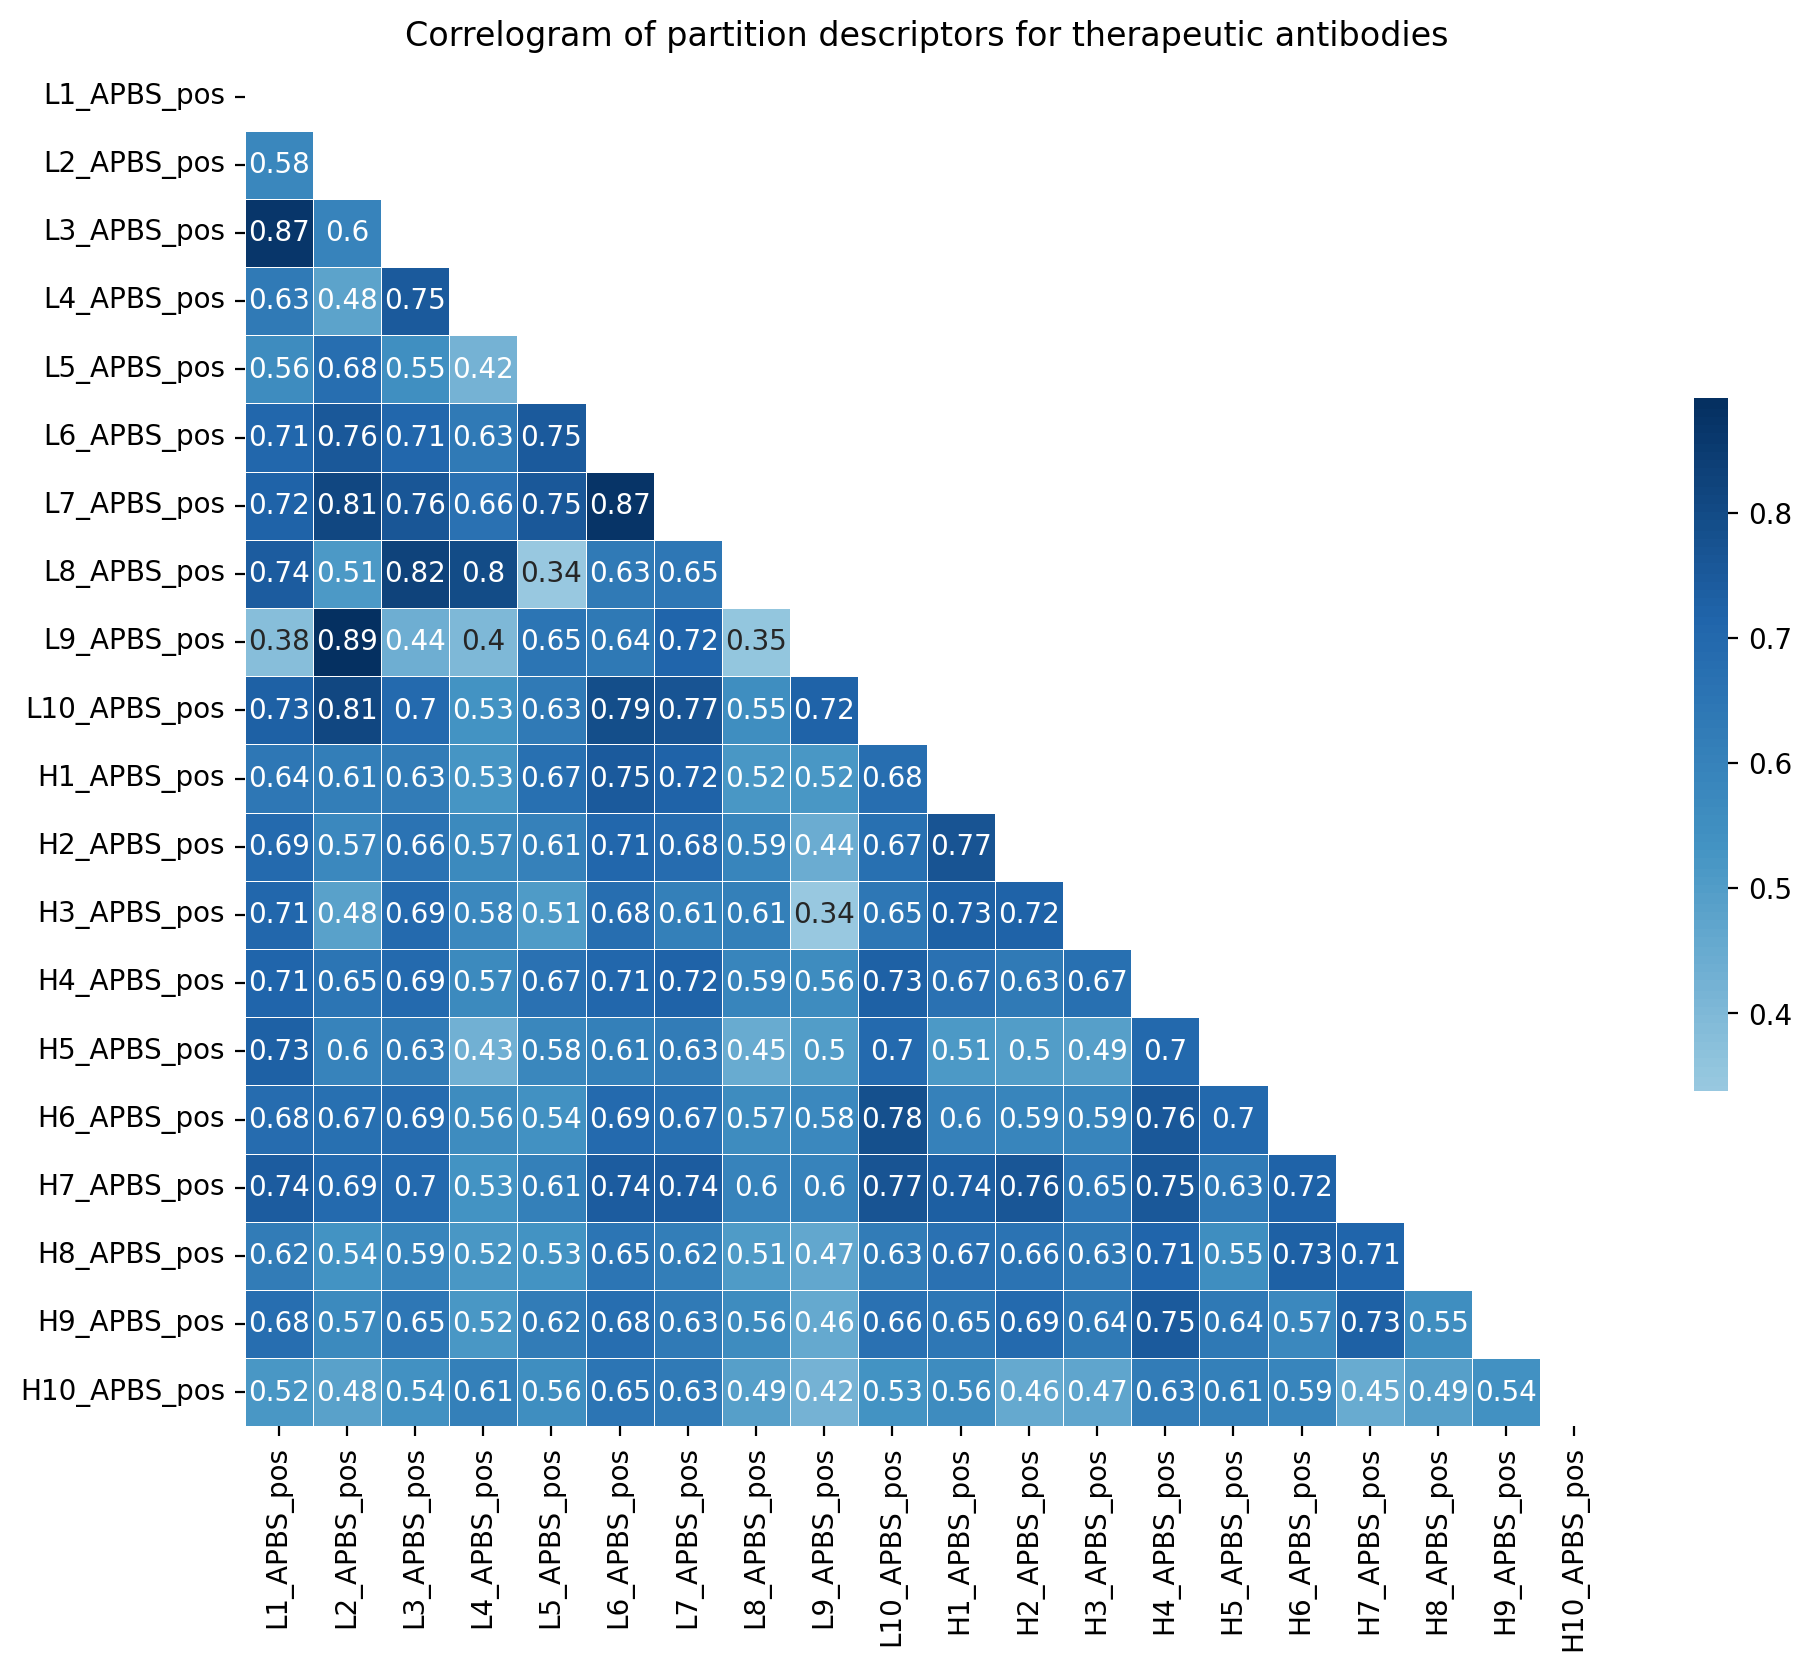

In [46]:
pos_cols = [col  for col in tab_partitions.columns if 'pos' in col]
neg_cols = [col  for col in tab_partitions.columns if 'neg' in col]
net_cols = [col for col in tab_partitions.columns if 'net' in col]
plot_correlogram(tab_partitions[pos_cols], title = 'Correlogram of partition descriptors for therapeutic antibodies', annot=True)

<Axes: title={'center': 'Correlogram of partition descriptors for therapeutic antibodies'}>

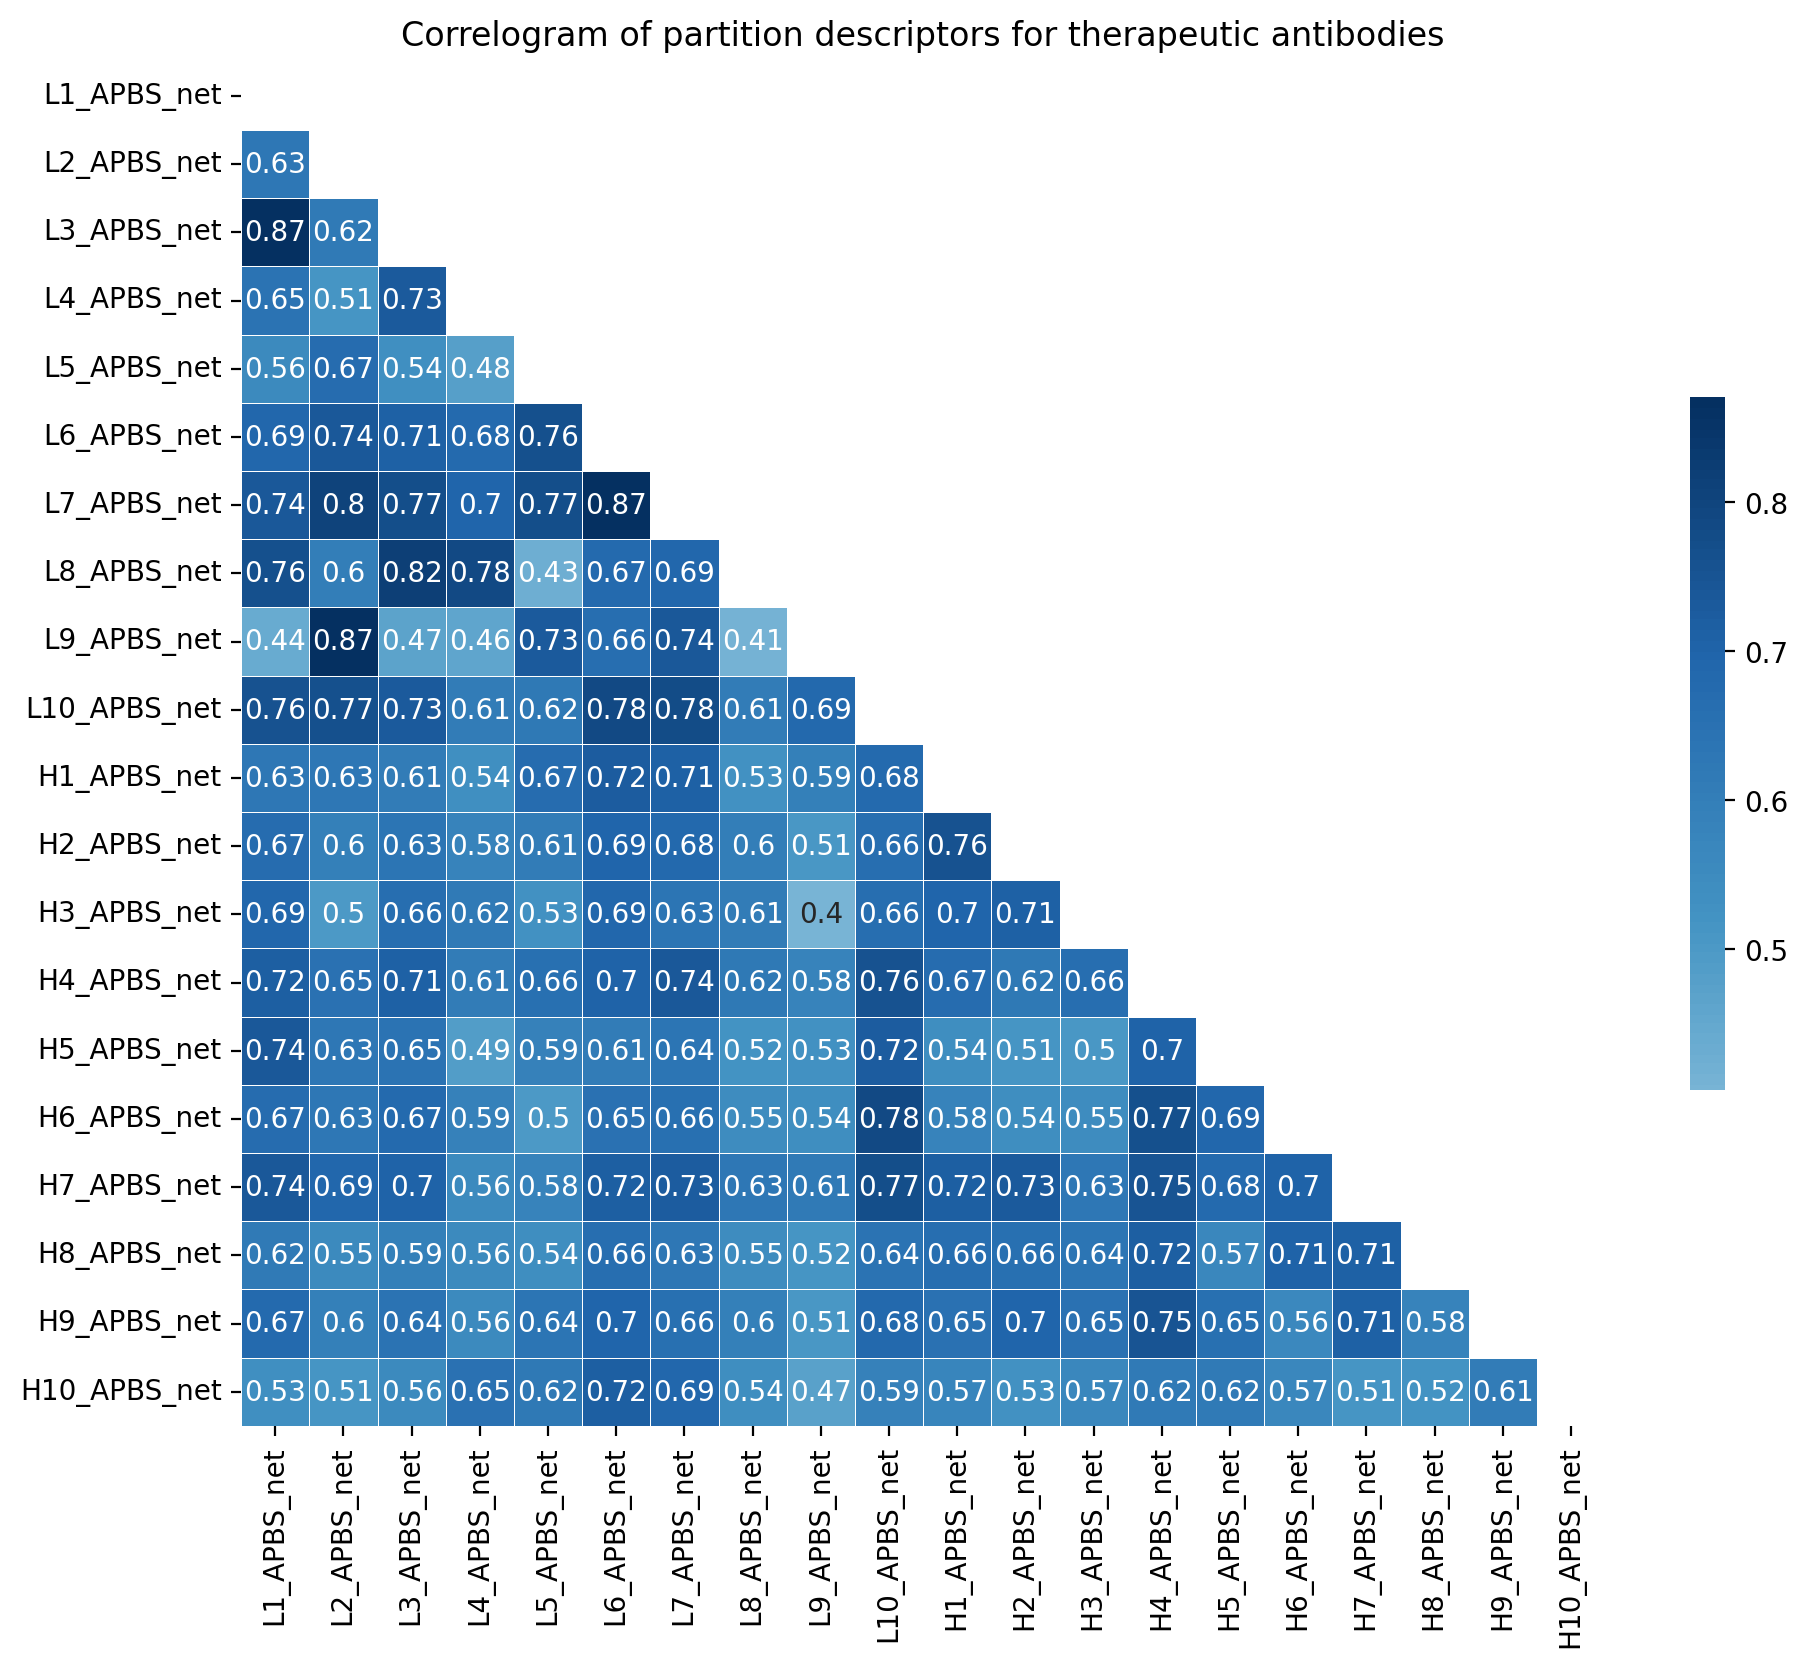

In [47]:
plot_correlogram(tab_partitions[net_cols], title = 'Correlogram of partition descriptors for therapeutic antibodies', annot=True)

<Axes: title={'center': 'Correlogram of partition descriptors for MPK190 variants'}>

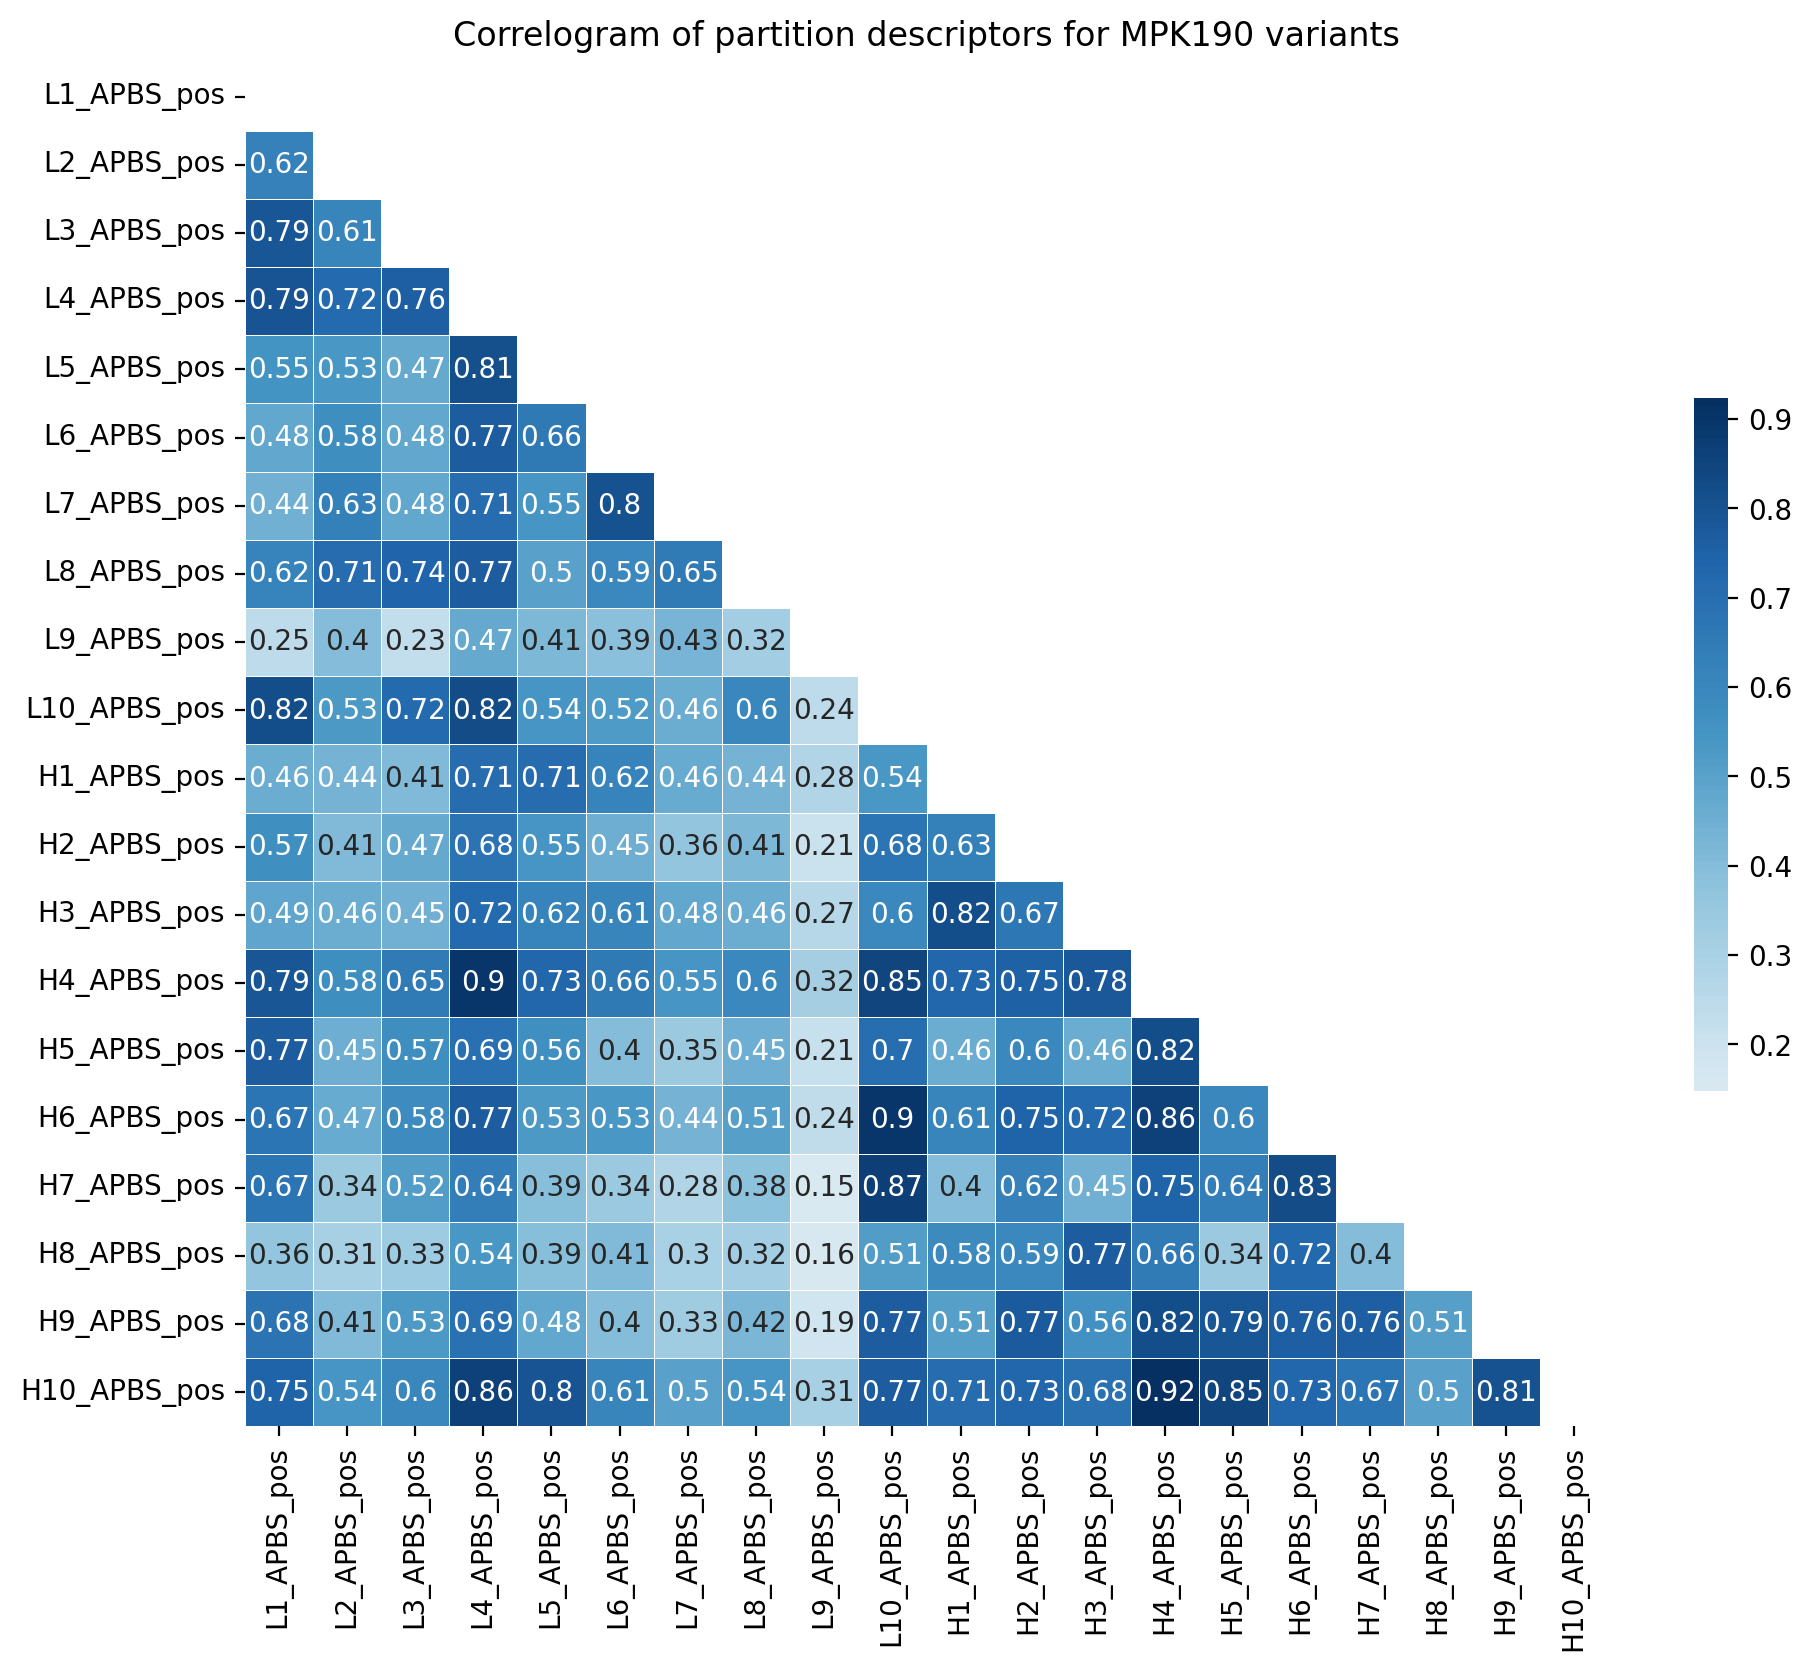

In [48]:

plot_correlogram(mpk190_partitions[pos_cols], title = 'Correlogram of partition descriptors for MPK190 variants', annot=True)

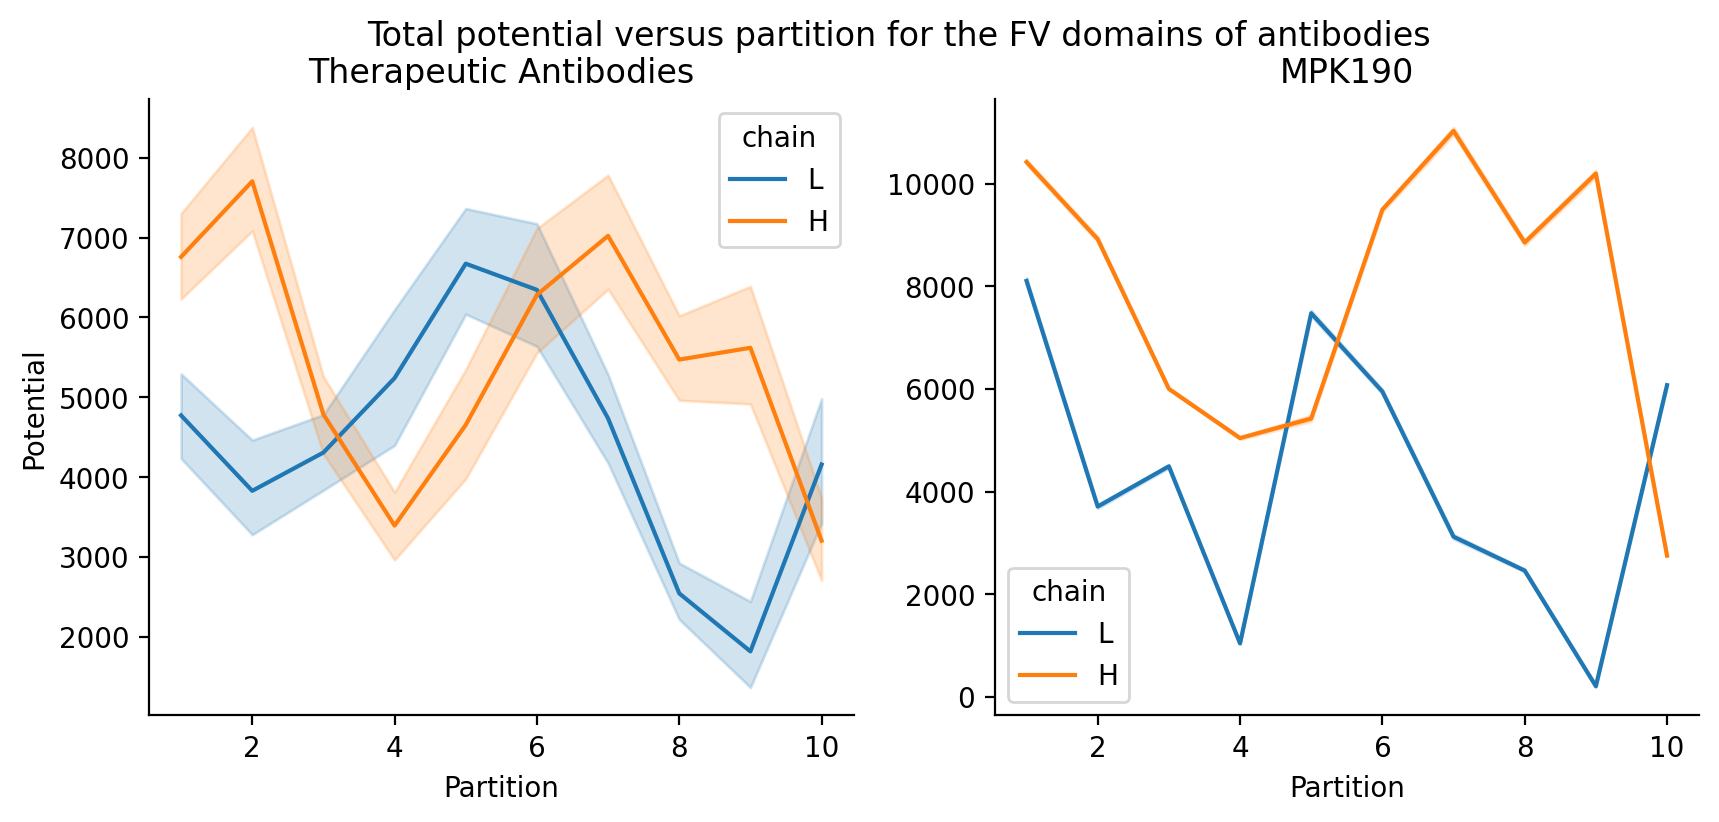

In [49]:
tab_parts = tab_partitions[pos_cols].T
index = tab_parts.index.str.replace('_APBS_pos', '')
tab_parts['chain'] = index.str[0]
tab_parts['partition']= index.str[1:].astype(int)
tab_parts = tab_parts.melt(id_vars=['chain', 'partition'], var_name='residue', value_name='potential')

mpk190_parts = mpk190_partitions[pos_cols].T
index = mpk190_parts.index.str.replace('_APBS_pos', '')
mpk190_parts['chain'] = index.str[0]
mpk190_parts['partition']= index.str[1:].astype(int)
mpk190_parts = mpk190_parts.melt(id_vars=['chain', 'partition'], var_name='residue', value_name='potential')



fig, axes = plt.subplots(1,2, figsize=(10,4))
ax = sns.lineplot(tab_parts, x = 'partition', y = 'potential', hue='chain', ax = axes[0])
ax.set(title ='Therapeutic Antibodies', xlabel='Partition', ylabel='Potential')


ax = sns.lineplot(mpk190_parts, x = 'partition', y = 'potential', hue='chain', ax = axes[1])
ax.set(title = 'MPK190', xlabel='Partition', ylabel='')

fig.suptitle('Total potential versus partition for the FV domains of antibodies')
sns.despine()


### Look at Exponetial weighted moving average of the potential

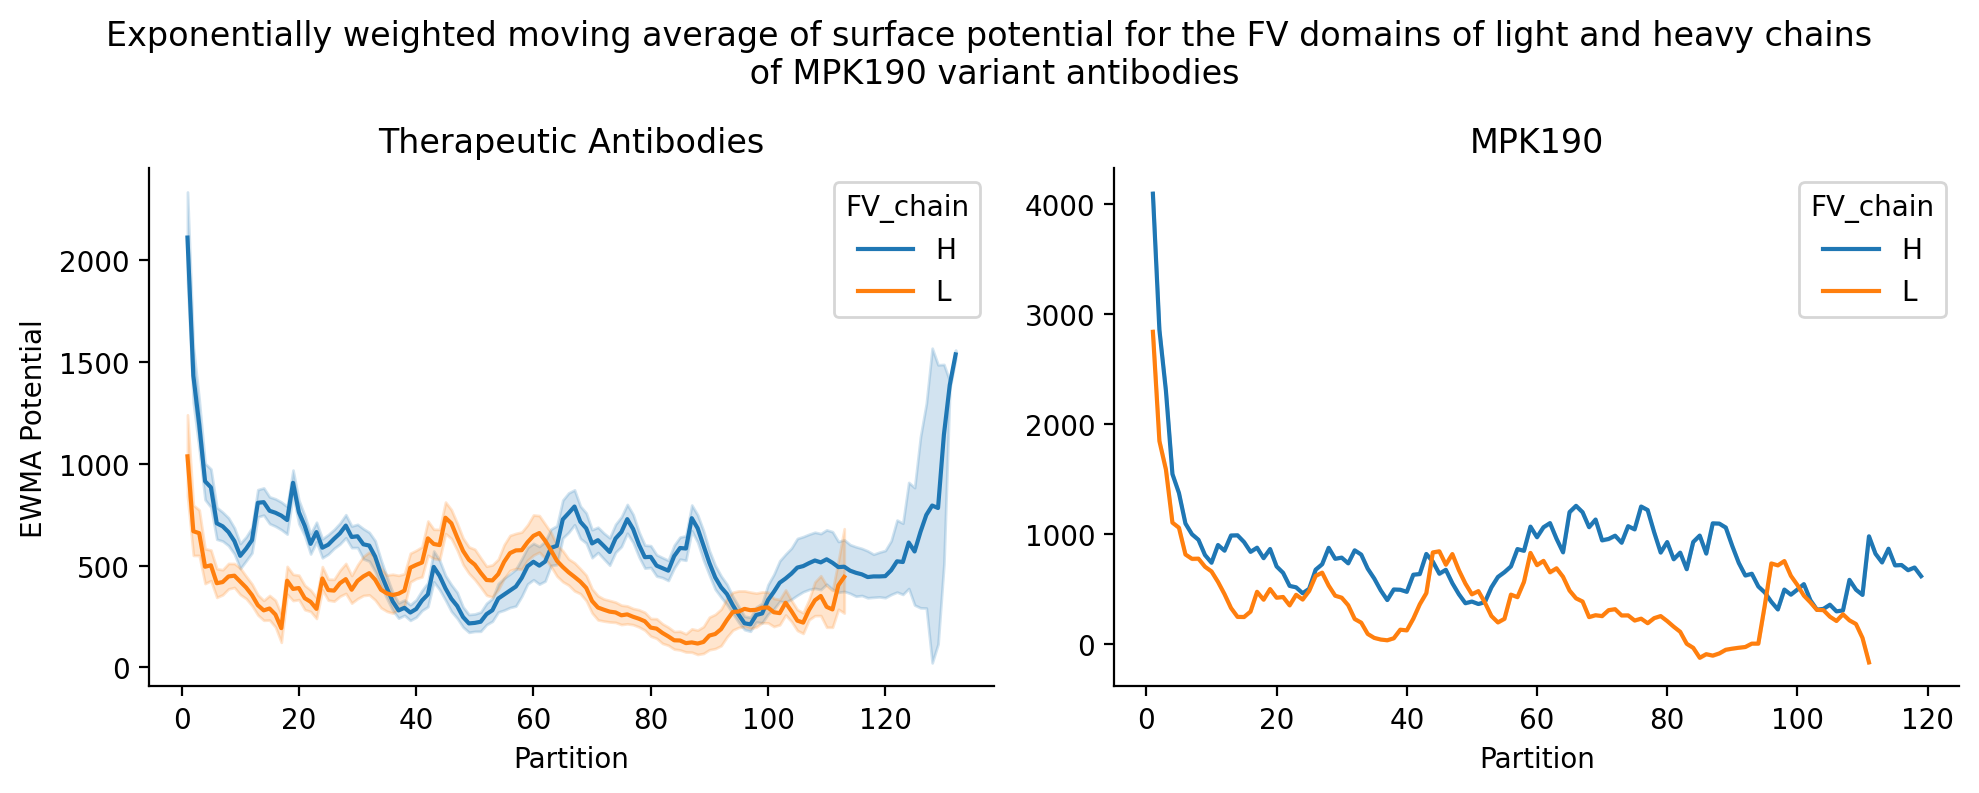

In [50]:
def compute_ewm(df,span=10): 
    ma  = df['total_pot'].ewm(span=span).mean()
    return pd.DataFrame(dict(number = range(1, len(ma)+1), ewm_pot = ma))


tab_ewm = tab_potentials.groupby(['name', 'FV_chain']).apply(compute_ewm)
mpk190_ewm = mpk_potentials.groupby(['name', 'FV_chain']).apply(compute_ewm)


fig, axes = plt.subplots(1,2, figsize=(10,4))

ax = sns.lineplot(data = tab_ewm, x = 'number', y='ewm_pot', hue = 'FV_chain', ax = axes[0])
ax.set(xlabel = 'Partition', ylabel = "EWMA Potential", title = 'Therapeutic Antibodies')

ax = sns.lineplot(data = mpk190_ewm, x = 'number', y='ewm_pot', hue = 'FV_chain', ax = axes[1])
ax.set(xlabel = 'Partition', ylabel = '', title = 'MPK190')


fig.suptitle('Exponentially weighted moving average of surface potential for the FV domains of light and heavy chains\n of MPK190 variant antibodies')
sns.despine()
plt.tight_layout()